# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = 'data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

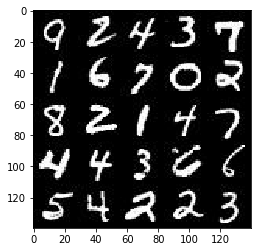

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

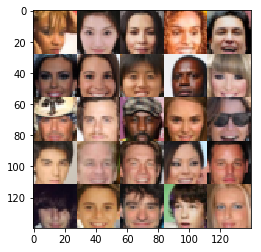

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input_images')
    z_data = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_data')
    learningRate = tf.placeholder(tf.float32, name='learning_rate') 

    
    return real_input_images, z_data, learningRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [20]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha= 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images,64,5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        dropout_layer = tf.layers.dropout(inputs=flat, rate=0.75)
        logits = tf.layers.dense(dropout_layer, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x104 now

        x2 = tf.layers.conv2d_transpose(x1, 512, 4, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 4x4x512 now
        x3 = tf.layers.conv2d_transpose(x2, 256, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        x4 = tf.layers.conv2d_transpose(x3, 128, 4, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        #x4 = tf.layers.dropout(x4, rate=0.7)
        x4 = tf.maximum(alpha * x4, x4)
                                           
        
                                           
                                           

        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
    
    return out 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim, smooth =0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real,)
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean( 
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels= tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    #sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    n_images = 9

    # Inputs
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    # Loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    # Optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                batch_images = 2*batch_images

                #Step 1. Random Noise to feed into G
                batch_z = np.random.uniform(-1, 1, size=(batch_size,z_dim))

                #Step 2. Run Optimizers
                # _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr : learning_rate, beta1: beta1})
                #_ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real: get_batches, lr : learning_rate, beta1 : beta1})

                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr : learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real: batch_images, lr : learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Step{}".format(steps),
                          "Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess,n_images=9,input_z=input_z,out_channel_dim=data_shape[3],image_mode=data_image_mode)

       

  

    return losses, samples       

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step10 Epoch 1/2... Discriminator Loss: 4.7452... Generator Loss: 0.0148
Step20 Epoch 1/2... Discriminator Loss: 5.2925... Generator Loss: 0.0102
Step30 Epoch 1/2... Discriminator Loss: 3.5580... Generator Loss: 0.0516
Step40 Epoch 1/2... Discriminator Loss: 3.4648... Generator Loss: 0.0576
Step50 Epoch 1/2... Discriminator Loss: 1.9813... Generator Loss: 0.7721
Step60 Epoch 1/2... Discriminator Loss: 2.2350... Generator Loss: 0.2021
Step70 Epoch 1/2... Discriminator Loss: 1.9478... Generator Loss: 0.5415
Step80 Epoch 1/2... Discriminator Loss: 1.9254... Generator Loss: 0.3611
Step90 Epoch 1/2... Discriminator Loss: 1.9577... Generator Loss: 0.2775
Step100 Epoch 1/2... Discriminator Loss: 2.2378... Generator Loss: 0.1806


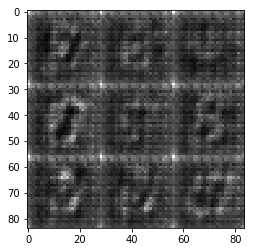

Step110 Epoch 1/2... Discriminator Loss: 1.5811... Generator Loss: 0.4820
Step120 Epoch 1/2... Discriminator Loss: 1.8747... Generator Loss: 0.2619
Step130 Epoch 1/2... Discriminator Loss: 1.4956... Generator Loss: 0.4689
Step140 Epoch 1/2... Discriminator Loss: 1.7592... Generator Loss: 0.3368
Step150 Epoch 1/2... Discriminator Loss: 1.5063... Generator Loss: 0.5650
Step160 Epoch 1/2... Discriminator Loss: 1.8013... Generator Loss: 0.2995
Step170 Epoch 1/2... Discriminator Loss: 1.5417... Generator Loss: 0.4806
Step180 Epoch 1/2... Discriminator Loss: 1.9484... Generator Loss: 0.2383
Step190 Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 1.0280
Step200 Epoch 1/2... Discriminator Loss: 1.6313... Generator Loss: 0.3849


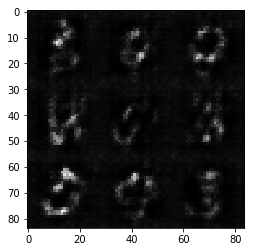

Step210 Epoch 1/2... Discriminator Loss: 2.0536... Generator Loss: 0.2151
Step220 Epoch 1/2... Discriminator Loss: 1.7036... Generator Loss: 1.7089
Step230 Epoch 1/2... Discriminator Loss: 1.3677... Generator Loss: 0.5857
Step240 Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.6776
Step250 Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 1.3281
Step260 Epoch 1/2... Discriminator Loss: 1.9568... Generator Loss: 0.2523
Step270 Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.7148
Step280 Epoch 1/2... Discriminator Loss: 1.3406... Generator Loss: 0.6769
Step290 Epoch 1/2... Discriminator Loss: 1.2840... Generator Loss: 1.0846
Step300 Epoch 1/2... Discriminator Loss: 1.4562... Generator Loss: 1.0694


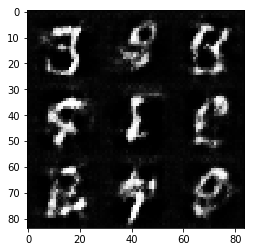

Step310 Epoch 1/2... Discriminator Loss: 1.6402... Generator Loss: 0.3863
Step320 Epoch 1/2... Discriminator Loss: 1.4550... Generator Loss: 1.2885
Step330 Epoch 1/2... Discriminator Loss: 1.3959... Generator Loss: 0.5002
Step340 Epoch 1/2... Discriminator Loss: 1.3583... Generator Loss: 1.0328
Step350 Epoch 1/2... Discriminator Loss: 1.2397... Generator Loss: 1.2009
Step360 Epoch 1/2... Discriminator Loss: 1.2211... Generator Loss: 1.0236
Step370 Epoch 1/2... Discriminator Loss: 1.5099... Generator Loss: 0.4382
Step380 Epoch 1/2... Discriminator Loss: 1.3466... Generator Loss: 1.2833
Step390 Epoch 1/2... Discriminator Loss: 1.8792... Generator Loss: 0.2643
Step400 Epoch 1/2... Discriminator Loss: 1.4999... Generator Loss: 1.0459


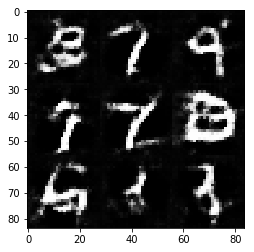

Step410 Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 0.9627
Step420 Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 1.0025
Step430 Epoch 1/2... Discriminator Loss: 1.2524... Generator Loss: 0.9966
Step440 Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 0.5603
Step450 Epoch 1/2... Discriminator Loss: 1.3909... Generator Loss: 0.5325
Step460 Epoch 1/2... Discriminator Loss: 1.5620... Generator Loss: 0.4327
Step470 Epoch 1/2... Discriminator Loss: 1.4149... Generator Loss: 0.4989
Step480 Epoch 1/2... Discriminator Loss: 1.3386... Generator Loss: 0.8583
Step490 Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 0.7551
Step500 Epoch 1/2... Discriminator Loss: 1.4340... Generator Loss: 0.6630


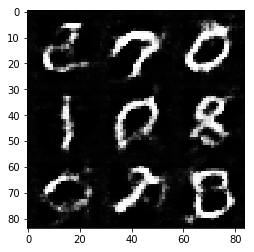

Step510 Epoch 1/2... Discriminator Loss: 1.7249... Generator Loss: 0.3548
Step520 Epoch 1/2... Discriminator Loss: 1.3537... Generator Loss: 0.9710
Step530 Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.6554
Step540 Epoch 1/2... Discriminator Loss: 1.2373... Generator Loss: 0.6891
Step550 Epoch 1/2... Discriminator Loss: 1.2233... Generator Loss: 0.8995
Step560 Epoch 1/2... Discriminator Loss: 1.2803... Generator Loss: 0.7419
Step570 Epoch 1/2... Discriminator Loss: 1.2399... Generator Loss: 0.7284
Step580 Epoch 1/2... Discriminator Loss: 1.5102... Generator Loss: 0.4298
Step590 Epoch 1/2... Discriminator Loss: 1.3678... Generator Loss: 0.7728
Step600 Epoch 1/2... Discriminator Loss: 1.3668... Generator Loss: 1.2673


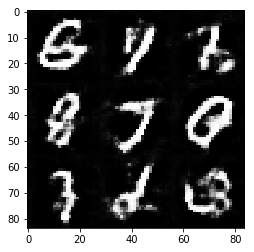

Step610 Epoch 1/2... Discriminator Loss: 1.2989... Generator Loss: 0.8228
Step620 Epoch 1/2... Discriminator Loss: 1.2702... Generator Loss: 0.8165
Step630 Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 1.0284
Step640 Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 0.8162
Step650 Epoch 1/2... Discriminator Loss: 1.2873... Generator Loss: 0.9708
Step660 Epoch 1/2... Discriminator Loss: 1.3254... Generator Loss: 0.9121
Step670 Epoch 1/2... Discriminator Loss: 1.1490... Generator Loss: 0.9956
Step680 Epoch 1/2... Discriminator Loss: 1.3944... Generator Loss: 0.6903
Step690 Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 1.0203
Step700 Epoch 1/2... Discriminator Loss: 1.1694... Generator Loss: 0.9791


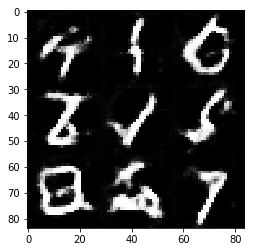

Step710 Epoch 1/2... Discriminator Loss: 1.2077... Generator Loss: 0.8999
Step720 Epoch 1/2... Discriminator Loss: 1.4187... Generator Loss: 1.1800
Step730 Epoch 1/2... Discriminator Loss: 1.5375... Generator Loss: 0.4305
Step740 Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.8639
Step750 Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 0.7437
Step760 Epoch 1/2... Discriminator Loss: 1.2764... Generator Loss: 1.1402
Step770 Epoch 1/2... Discriminator Loss: 1.4985... Generator Loss: 0.4686
Step780 Epoch 1/2... Discriminator Loss: 1.3945... Generator Loss: 0.5107
Step790 Epoch 1/2... Discriminator Loss: 1.4410... Generator Loss: 0.5021
Step800 Epoch 1/2... Discriminator Loss: 1.3061... Generator Loss: 1.3615


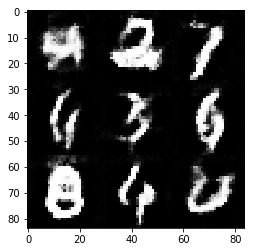

Step810 Epoch 1/2... Discriminator Loss: 1.3952... Generator Loss: 0.5870
Step820 Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.9376
Step830 Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 0.7506
Step840 Epoch 1/2... Discriminator Loss: 1.7094... Generator Loss: 0.3486
Step850 Epoch 1/2... Discriminator Loss: 1.2756... Generator Loss: 0.8572
Step860 Epoch 1/2... Discriminator Loss: 1.3111... Generator Loss: 0.5868
Step870 Epoch 1/2... Discriminator Loss: 1.5585... Generator Loss: 0.4021
Step880 Epoch 1/2... Discriminator Loss: 1.1349... Generator Loss: 0.9431
Step890 Epoch 1/2... Discriminator Loss: 1.2595... Generator Loss: 0.7034
Step900 Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.5679


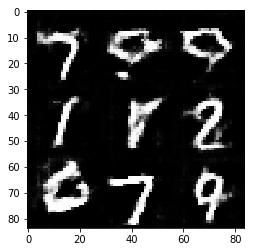

Step910 Epoch 1/2... Discriminator Loss: 1.4139... Generator Loss: 0.4872
Step920 Epoch 1/2... Discriminator Loss: 1.5369... Generator Loss: 0.4180
Step930 Epoch 1/2... Discriminator Loss: 1.5648... Generator Loss: 0.4121
Step940 Epoch 1/2... Discriminator Loss: 1.4960... Generator Loss: 0.4340
Step950 Epoch 1/2... Discriminator Loss: 1.5331... Generator Loss: 0.4223
Step960 Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 0.6967
Step970 Epoch 1/2... Discriminator Loss: 1.1932... Generator Loss: 1.1114
Step980 Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 0.4532
Step990 Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 1.1783
Step1000 Epoch 1/2... Discriminator Loss: 1.3654... Generator Loss: 1.1732


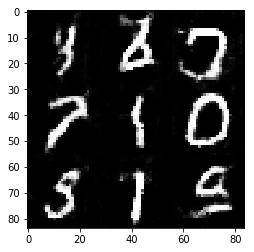

Step1010 Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 0.5680
Step1020 Epoch 1/2... Discriminator Loss: 1.4045... Generator Loss: 0.4753
Step1030 Epoch 1/2... Discriminator Loss: 1.2979... Generator Loss: 1.0997
Step1040 Epoch 1/2... Discriminator Loss: 1.3578... Generator Loss: 1.1476
Step1050 Epoch 1/2... Discriminator Loss: 1.3935... Generator Loss: 0.5567
Step1060 Epoch 1/2... Discriminator Loss: 1.1858... Generator Loss: 0.8071
Step1070 Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 0.5068
Step1080 Epoch 1/2... Discriminator Loss: 1.5910... Generator Loss: 0.3872
Step1090 Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.6179
Step1100 Epoch 1/2... Discriminator Loss: 1.4148... Generator Loss: 1.0742


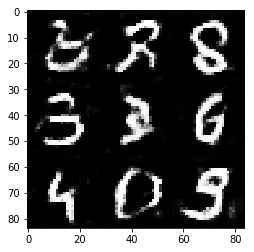

Step1110 Epoch 1/2... Discriminator Loss: 1.2027... Generator Loss: 0.7230
Step1120 Epoch 1/2... Discriminator Loss: 1.4553... Generator Loss: 0.4837
Step1130 Epoch 1/2... Discriminator Loss: 1.2937... Generator Loss: 0.6937
Step1140 Epoch 1/2... Discriminator Loss: 1.3040... Generator Loss: 0.5670
Step1150 Epoch 1/2... Discriminator Loss: 1.2380... Generator Loss: 0.6729
Step1160 Epoch 1/2... Discriminator Loss: 1.4256... Generator Loss: 0.6208
Step1170 Epoch 1/2... Discriminator Loss: 1.3409... Generator Loss: 0.5920
Step1180 Epoch 1/2... Discriminator Loss: 1.2410... Generator Loss: 0.7551
Step1190 Epoch 1/2... Discriminator Loss: 1.2888... Generator Loss: 0.9351
Step1200 Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 0.7614


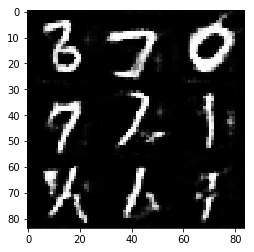

Step1210 Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.7277
Step1220 Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 1.0937
Step1230 Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: 1.3847
Step1240 Epoch 1/2... Discriminator Loss: 1.1308... Generator Loss: 0.8665
Step1250 Epoch 1/2... Discriminator Loss: 1.1425... Generator Loss: 1.2701
Step1260 Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 1.3241
Step1270 Epoch 1/2... Discriminator Loss: 1.7450... Generator Loss: 0.3449
Step1280 Epoch 1/2... Discriminator Loss: 1.2214... Generator Loss: 0.7495
Step1290 Epoch 1/2... Discriminator Loss: 1.4959... Generator Loss: 0.4692
Step1300 Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 1.1547


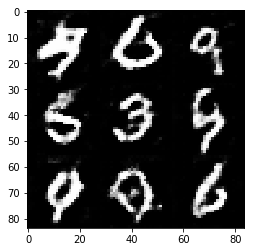

Step1310 Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 0.5357
Step1320 Epoch 1/2... Discriminator Loss: 1.2045... Generator Loss: 0.8744
Step1330 Epoch 1/2... Discriminator Loss: 1.2730... Generator Loss: 1.0888
Step1340 Epoch 1/2... Discriminator Loss: 1.1544... Generator Loss: 0.8347
Step1350 Epoch 1/2... Discriminator Loss: 1.2184... Generator Loss: 0.6196
Step1360 Epoch 1/2... Discriminator Loss: 1.2693... Generator Loss: 0.7008
Step1370 Epoch 1/2... Discriminator Loss: 1.0562... Generator Loss: 0.9758
Step1380 Epoch 1/2... Discriminator Loss: 1.1275... Generator Loss: 0.7552
Step1390 Epoch 1/2... Discriminator Loss: 1.2451... Generator Loss: 0.9629
Step1400 Epoch 1/2... Discriminator Loss: 1.5459... Generator Loss: 0.4288


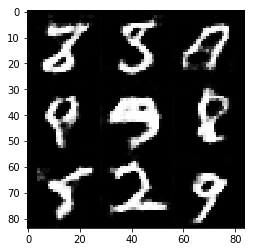

Step1410 Epoch 1/2... Discriminator Loss: 1.9485... Generator Loss: 2.8877
Step1420 Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.5840
Step1430 Epoch 1/2... Discriminator Loss: 1.1527... Generator Loss: 0.8422
Step1440 Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.5538
Step1450 Epoch 1/2... Discriminator Loss: 1.1378... Generator Loss: 1.1025
Step1460 Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 1.2383
Step1470 Epoch 1/2... Discriminator Loss: 1.1374... Generator Loss: 0.7940
Step1480 Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 1.5167
Step1490 Epoch 1/2... Discriminator Loss: 1.2313... Generator Loss: 1.2302
Step1500 Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 0.8108


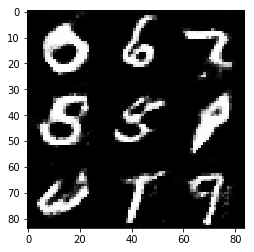

Step1510 Epoch 1/2... Discriminator Loss: 1.2192... Generator Loss: 0.7511
Step1520 Epoch 1/2... Discriminator Loss: 1.7651... Generator Loss: 0.3265
Step1530 Epoch 1/2... Discriminator Loss: 1.2578... Generator Loss: 1.0408
Step1540 Epoch 1/2... Discriminator Loss: 1.1710... Generator Loss: 0.7423
Step1550 Epoch 1/2... Discriminator Loss: 1.1817... Generator Loss: 1.7384
Step1560 Epoch 1/2... Discriminator Loss: 1.3117... Generator Loss: 1.1834
Step1570 Epoch 1/2... Discriminator Loss: 1.6428... Generator Loss: 0.3886
Step1580 Epoch 1/2... Discriminator Loss: 1.2511... Generator Loss: 0.6382
Step1590 Epoch 1/2... Discriminator Loss: 1.0581... Generator Loss: 1.0427
Step1600 Epoch 1/2... Discriminator Loss: 1.0633... Generator Loss: 0.8699


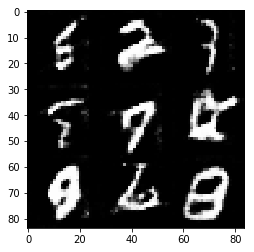

Step1610 Epoch 1/2... Discriminator Loss: 1.1088... Generator Loss: 0.7509
Step1620 Epoch 1/2... Discriminator Loss: 1.3173... Generator Loss: 0.5405
Step1630 Epoch 1/2... Discriminator Loss: 1.1290... Generator Loss: 0.7757
Step1640 Epoch 1/2... Discriminator Loss: 1.1244... Generator Loss: 0.7408
Step1650 Epoch 1/2... Discriminator Loss: 1.2132... Generator Loss: 1.3645
Step1660 Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 1.1954
Step1670 Epoch 1/2... Discriminator Loss: 1.1347... Generator Loss: 0.7649
Step1680 Epoch 1/2... Discriminator Loss: 1.0023... Generator Loss: 1.3109
Step1690 Epoch 1/2... Discriminator Loss: 1.1287... Generator Loss: 0.8650
Step1700 Epoch 1/2... Discriminator Loss: 1.4844... Generator Loss: 0.4355


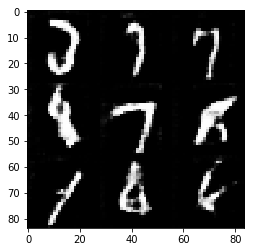

Step1710 Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 0.7683
Step1720 Epoch 1/2... Discriminator Loss: 1.1036... Generator Loss: 0.8153
Step1730 Epoch 1/2... Discriminator Loss: 1.1266... Generator Loss: 0.8343
Step1740 Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 0.7762
Step1750 Epoch 1/2... Discriminator Loss: 1.2371... Generator Loss: 1.5280
Step1760 Epoch 1/2... Discriminator Loss: 1.0018... Generator Loss: 0.9350
Step1770 Epoch 1/2... Discriminator Loss: 1.1329... Generator Loss: 0.9573
Step1780 Epoch 1/2... Discriminator Loss: 1.3479... Generator Loss: 0.5909
Step1790 Epoch 1/2... Discriminator Loss: 1.0545... Generator Loss: 0.9062
Step1800 Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 0.5259


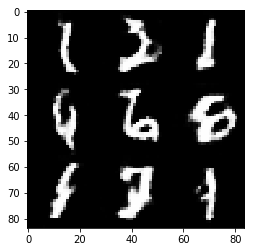

Step1810 Epoch 1/2... Discriminator Loss: 1.0017... Generator Loss: 0.9332
Step1820 Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 1.8110
Step1830 Epoch 1/2... Discriminator Loss: 1.4435... Generator Loss: 0.5821
Step1840 Epoch 1/2... Discriminator Loss: 1.2158... Generator Loss: 1.2477
Step1850 Epoch 1/2... Discriminator Loss: 1.0779... Generator Loss: 0.9382
Step1860 Epoch 1/2... Discriminator Loss: 1.2929... Generator Loss: 0.5782
Step1870 Epoch 1/2... Discriminator Loss: 0.9558... Generator Loss: 1.2200
Step1880 Epoch 2/2... Discriminator Loss: 1.2627... Generator Loss: 0.6176
Step1890 Epoch 2/2... Discriminator Loss: 1.2563... Generator Loss: 0.7278
Step1900 Epoch 2/2... Discriminator Loss: 1.1762... Generator Loss: 0.6770


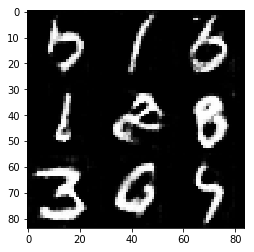

Step1910 Epoch 2/2... Discriminator Loss: 1.3728... Generator Loss: 0.5177
Step1920 Epoch 2/2... Discriminator Loss: 1.2735... Generator Loss: 0.5911
Step1930 Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.5164
Step1940 Epoch 2/2... Discriminator Loss: 1.0500... Generator Loss: 1.0112
Step1950 Epoch 2/2... Discriminator Loss: 1.4975... Generator Loss: 2.9646
Step1960 Epoch 2/2... Discriminator Loss: 0.9538... Generator Loss: 0.9893
Step1970 Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 0.8831
Step1980 Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 0.8326
Step1990 Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 0.7705
Step2000 Epoch 2/2... Discriminator Loss: 1.1941... Generator Loss: 0.6517


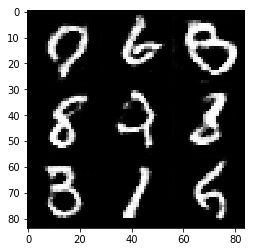

Step2010 Epoch 2/2... Discriminator Loss: 1.1030... Generator Loss: 1.1235
Step2020 Epoch 2/2... Discriminator Loss: 1.1207... Generator Loss: 0.8262
Step2030 Epoch 2/2... Discriminator Loss: 1.3273... Generator Loss: 0.5942
Step2040 Epoch 2/2... Discriminator Loss: 1.2097... Generator Loss: 0.6779
Step2050 Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.5057
Step2060 Epoch 2/2... Discriminator Loss: 1.1136... Generator Loss: 0.7499
Step2070 Epoch 2/2... Discriminator Loss: 1.1132... Generator Loss: 0.7040
Step2080 Epoch 2/2... Discriminator Loss: 0.9772... Generator Loss: 1.2299
Step2090 Epoch 2/2... Discriminator Loss: 1.1725... Generator Loss: 0.6547
Step2100 Epoch 2/2... Discriminator Loss: 0.7924... Generator Loss: 1.3796


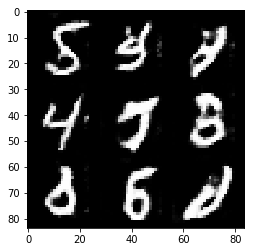

Step2110 Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 1.3294
Step2120 Epoch 2/2... Discriminator Loss: 1.2283... Generator Loss: 0.6610
Step2130 Epoch 2/2... Discriminator Loss: 1.2006... Generator Loss: 0.6576
Step2140 Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 0.8012
Step2150 Epoch 2/2... Discriminator Loss: 1.1713... Generator Loss: 0.8546
Step2160 Epoch 2/2... Discriminator Loss: 1.1498... Generator Loss: 1.3372
Step2170 Epoch 2/2... Discriminator Loss: 1.1061... Generator Loss: 0.7314
Step2180 Epoch 2/2... Discriminator Loss: 1.5827... Generator Loss: 2.0947
Step2190 Epoch 2/2... Discriminator Loss: 0.9899... Generator Loss: 0.8555
Step2200 Epoch 2/2... Discriminator Loss: 1.2346... Generator Loss: 0.6242


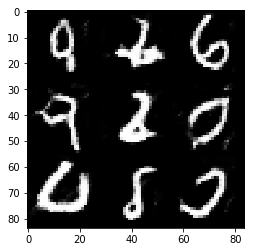

Step2210 Epoch 2/2... Discriminator Loss: 1.2992... Generator Loss: 0.5539
Step2220 Epoch 2/2... Discriminator Loss: 1.1191... Generator Loss: 0.7013
Step2230 Epoch 2/2... Discriminator Loss: 0.9541... Generator Loss: 0.9614
Step2240 Epoch 2/2... Discriminator Loss: 1.3442... Generator Loss: 1.8527
Step2250 Epoch 2/2... Discriminator Loss: 0.8658... Generator Loss: 1.6339
Step2260 Epoch 2/2... Discriminator Loss: 1.3423... Generator Loss: 0.5167
Step2270 Epoch 2/2... Discriminator Loss: 1.8983... Generator Loss: 1.6503
Step2280 Epoch 2/2... Discriminator Loss: 1.1169... Generator Loss: 1.1054
Step2290 Epoch 2/2... Discriminator Loss: 0.9598... Generator Loss: 1.0794
Step2300 Epoch 2/2... Discriminator Loss: 0.9690... Generator Loss: 0.9206


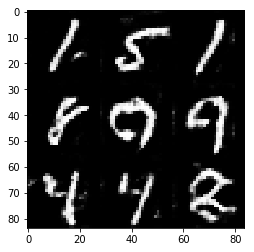

Step2310 Epoch 2/2... Discriminator Loss: 0.9963... Generator Loss: 0.9073
Step2320 Epoch 2/2... Discriminator Loss: 1.6186... Generator Loss: 0.3816
Step2330 Epoch 2/2... Discriminator Loss: 0.9723... Generator Loss: 1.6614
Step2340 Epoch 2/2... Discriminator Loss: 0.9727... Generator Loss: 1.1778
Step2350 Epoch 2/2... Discriminator Loss: 1.3033... Generator Loss: 0.6106
Step2360 Epoch 2/2... Discriminator Loss: 0.9432... Generator Loss: 1.7290
Step2370 Epoch 2/2... Discriminator Loss: 0.9180... Generator Loss: 1.3838
Step2380 Epoch 2/2... Discriminator Loss: 0.8731... Generator Loss: 1.4671
Step2390 Epoch 2/2... Discriminator Loss: 1.0050... Generator Loss: 0.9758
Step2400 Epoch 2/2... Discriminator Loss: 0.8797... Generator Loss: 1.2761


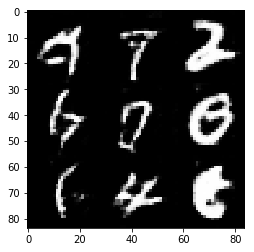

Step2410 Epoch 2/2... Discriminator Loss: 1.1511... Generator Loss: 0.6753
Step2420 Epoch 2/2... Discriminator Loss: 1.0233... Generator Loss: 0.9559
Step2430 Epoch 2/2... Discriminator Loss: 1.0849... Generator Loss: 1.1969
Step2440 Epoch 2/2... Discriminator Loss: 1.0815... Generator Loss: 0.9889
Step2450 Epoch 2/2... Discriminator Loss: 1.3564... Generator Loss: 0.5506
Step2460 Epoch 2/2... Discriminator Loss: 0.9375... Generator Loss: 1.1087
Step2470 Epoch 2/2... Discriminator Loss: 1.1090... Generator Loss: 0.7395
Step2480 Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 0.5888
Step2490 Epoch 2/2... Discriminator Loss: 1.3516... Generator Loss: 0.5852
Step2500 Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 0.9532


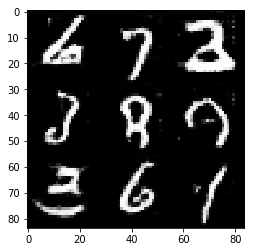

Step2510 Epoch 2/2... Discriminator Loss: 1.0136... Generator Loss: 1.0445
Step2520 Epoch 2/2... Discriminator Loss: 1.3460... Generator Loss: 0.5380
Step2530 Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 0.8379
Step2540 Epoch 2/2... Discriminator Loss: 1.1818... Generator Loss: 0.7234
Step2550 Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 1.1876
Step2560 Epoch 2/2... Discriminator Loss: 1.1030... Generator Loss: 1.8738
Step2570 Epoch 2/2... Discriminator Loss: 1.2909... Generator Loss: 1.8091
Step2580 Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 0.8050
Step2590 Epoch 2/2... Discriminator Loss: 1.0310... Generator Loss: 0.8160
Step2600 Epoch 2/2... Discriminator Loss: 1.1998... Generator Loss: 0.6261


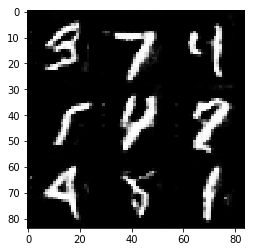

Step2610 Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 1.7259
Step2620 Epoch 2/2... Discriminator Loss: 1.0935... Generator Loss: 1.9980
Step2630 Epoch 2/2... Discriminator Loss: 1.0325... Generator Loss: 0.8347
Step2640 Epoch 2/2... Discriminator Loss: 0.8584... Generator Loss: 1.3319
Step2650 Epoch 2/2... Discriminator Loss: 1.6562... Generator Loss: 0.3859
Step2660 Epoch 2/2... Discriminator Loss: 0.8793... Generator Loss: 1.0980
Step2670 Epoch 2/2... Discriminator Loss: 0.9150... Generator Loss: 1.5310
Step2680 Epoch 2/2... Discriminator Loss: 0.7783... Generator Loss: 1.6618
Step2690 Epoch 2/2... Discriminator Loss: 0.8729... Generator Loss: 1.0460
Step2700 Epoch 2/2... Discriminator Loss: 1.0068... Generator Loss: 1.8808


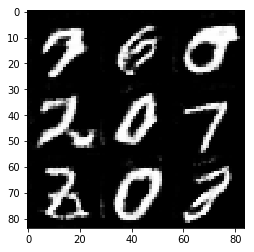

Step2710 Epoch 2/2... Discriminator Loss: 0.9921... Generator Loss: 0.8763
Step2720 Epoch 2/2... Discriminator Loss: 0.9868... Generator Loss: 0.9982
Step2730 Epoch 2/2... Discriminator Loss: 0.8547... Generator Loss: 1.6387
Step2740 Epoch 2/2... Discriminator Loss: 1.2185... Generator Loss: 0.6709
Step2750 Epoch 2/2... Discriminator Loss: 1.1269... Generator Loss: 0.7124
Step2760 Epoch 2/2... Discriminator Loss: 0.9349... Generator Loss: 0.9863
Step2770 Epoch 2/2... Discriminator Loss: 0.9746... Generator Loss: 0.9822
Step2780 Epoch 2/2... Discriminator Loss: 0.7846... Generator Loss: 1.7372
Step2790 Epoch 2/2... Discriminator Loss: 0.9820... Generator Loss: 0.9029
Step2800 Epoch 2/2... Discriminator Loss: 1.3621... Generator Loss: 1.8992


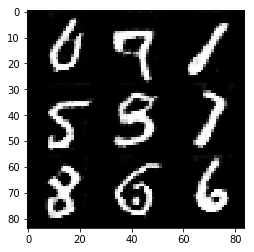

Step2810 Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 0.9119
Step2820 Epoch 2/2... Discriminator Loss: 0.9279... Generator Loss: 0.9394
Step2830 Epoch 2/2... Discriminator Loss: 0.9746... Generator Loss: 0.9462
Step2840 Epoch 2/2... Discriminator Loss: 1.0698... Generator Loss: 1.1566
Step2850 Epoch 2/2... Discriminator Loss: 0.9650... Generator Loss: 1.2966
Step2860 Epoch 2/2... Discriminator Loss: 1.0645... Generator Loss: 0.8688
Step2870 Epoch 2/2... Discriminator Loss: 1.0314... Generator Loss: 1.1022
Step2880 Epoch 2/2... Discriminator Loss: 1.0557... Generator Loss: 0.8518
Step2890 Epoch 2/2... Discriminator Loss: 0.9653... Generator Loss: 0.9455
Step2900 Epoch 2/2... Discriminator Loss: 0.9143... Generator Loss: 1.3475


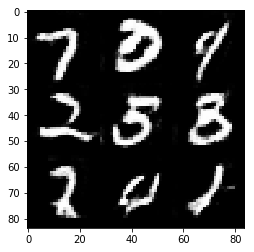

Step2910 Epoch 2/2... Discriminator Loss: 1.0022... Generator Loss: 0.9973
Step2920 Epoch 2/2... Discriminator Loss: 0.7550... Generator Loss: 1.6269
Step2930 Epoch 2/2... Discriminator Loss: 1.5748... Generator Loss: 0.4048
Step2940 Epoch 2/2... Discriminator Loss: 1.0161... Generator Loss: 0.7974
Step2950 Epoch 2/2... Discriminator Loss: 1.2159... Generator Loss: 0.6505
Step2960 Epoch 2/2... Discriminator Loss: 1.4334... Generator Loss: 0.4879
Step2970 Epoch 2/2... Discriminator Loss: 1.4671... Generator Loss: 0.4614
Step2980 Epoch 2/2... Discriminator Loss: 1.1992... Generator Loss: 0.6167
Step2990 Epoch 2/2... Discriminator Loss: 1.2240... Generator Loss: 2.3047
Step3000 Epoch 2/2... Discriminator Loss: 1.1547... Generator Loss: 0.8332


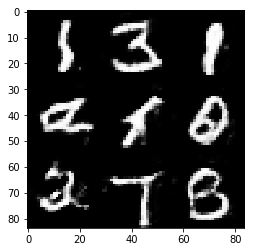

Step3010 Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 2.0312
Step3020 Epoch 2/2... Discriminator Loss: 1.2258... Generator Loss: 0.7203
Step3030 Epoch 2/2... Discriminator Loss: 0.9400... Generator Loss: 1.3931
Step3040 Epoch 2/2... Discriminator Loss: 1.3228... Generator Loss: 0.5566
Step3050 Epoch 2/2... Discriminator Loss: 0.8304... Generator Loss: 1.2091
Step3060 Epoch 2/2... Discriminator Loss: 1.4558... Generator Loss: 0.4814
Step3070 Epoch 2/2... Discriminator Loss: 1.1399... Generator Loss: 0.7759
Step3080 Epoch 2/2... Discriminator Loss: 0.9790... Generator Loss: 1.1094
Step3090 Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 1.0030
Step3100 Epoch 2/2... Discriminator Loss: 0.9690... Generator Loss: 2.0558


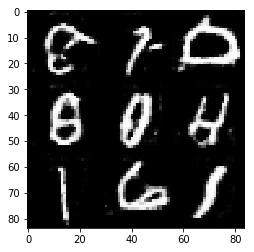

Step3110 Epoch 2/2... Discriminator Loss: 0.7954... Generator Loss: 1.3516
Step3120 Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 1.1563
Step3130 Epoch 2/2... Discriminator Loss: 0.8672... Generator Loss: 1.2139
Step3140 Epoch 2/2... Discriminator Loss: 0.8738... Generator Loss: 1.9806
Step3150 Epoch 2/2... Discriminator Loss: 0.9525... Generator Loss: 0.9988
Step3160 Epoch 2/2... Discriminator Loss: 0.8273... Generator Loss: 1.1400
Step3170 Epoch 2/2... Discriminator Loss: 1.4287... Generator Loss: 0.5575
Step3180 Epoch 2/2... Discriminator Loss: 1.0606... Generator Loss: 0.9536
Step3190 Epoch 2/2... Discriminator Loss: 0.7856... Generator Loss: 1.6607
Step3200 Epoch 2/2... Discriminator Loss: 0.8893... Generator Loss: 1.4230


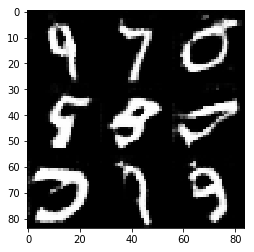

Step3210 Epoch 2/2... Discriminator Loss: 1.4020... Generator Loss: 0.5194
Step3220 Epoch 2/2... Discriminator Loss: 0.9838... Generator Loss: 0.9985
Step3230 Epoch 2/2... Discriminator Loss: 1.1965... Generator Loss: 0.7033
Step3240 Epoch 2/2... Discriminator Loss: 1.4538... Generator Loss: 0.5143
Step3250 Epoch 2/2... Discriminator Loss: 0.8192... Generator Loss: 1.2487
Step3260 Epoch 2/2... Discriminator Loss: 0.8526... Generator Loss: 1.0953
Step3270 Epoch 2/2... Discriminator Loss: 0.9781... Generator Loss: 0.8448
Step3280 Epoch 2/2... Discriminator Loss: 1.2667... Generator Loss: 0.5905
Step3290 Epoch 2/2... Discriminator Loss: 1.2764... Generator Loss: 0.5778
Step3300 Epoch 2/2... Discriminator Loss: 0.8777... Generator Loss: 1.1360


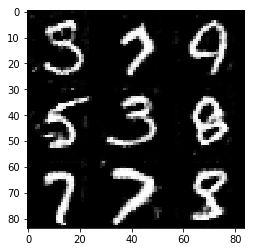

Step3310 Epoch 2/2... Discriminator Loss: 0.5993... Generator Loss: 1.8456
Step3320 Epoch 2/2... Discriminator Loss: 0.9518... Generator Loss: 0.9486
Step3330 Epoch 2/2... Discriminator Loss: 1.9928... Generator Loss: 0.2632
Step3340 Epoch 2/2... Discriminator Loss: 1.1291... Generator Loss: 0.9762
Step3350 Epoch 2/2... Discriminator Loss: 1.1063... Generator Loss: 0.7708
Step3360 Epoch 2/2... Discriminator Loss: 0.9697... Generator Loss: 1.6370
Step3370 Epoch 2/2... Discriminator Loss: 0.9370... Generator Loss: 1.3822
Step3380 Epoch 2/2... Discriminator Loss: 0.8240... Generator Loss: 1.6158
Step3390 Epoch 2/2... Discriminator Loss: 0.7767... Generator Loss: 1.2988
Step3400 Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 0.6999


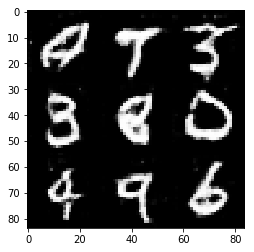

Step3410 Epoch 2/2... Discriminator Loss: 0.8705... Generator Loss: 1.9032
Step3420 Epoch 2/2... Discriminator Loss: 1.0380... Generator Loss: 0.9469
Step3430 Epoch 2/2... Discriminator Loss: 0.8277... Generator Loss: 1.4142
Step3440 Epoch 2/2... Discriminator Loss: 1.2643... Generator Loss: 0.6295
Step3450 Epoch 2/2... Discriminator Loss: 0.8133... Generator Loss: 1.1850
Step3460 Epoch 2/2... Discriminator Loss: 1.0660... Generator Loss: 0.9555
Step3470 Epoch 2/2... Discriminator Loss: 0.8231... Generator Loss: 1.2044
Step3480 Epoch 2/2... Discriminator Loss: 1.6491... Generator Loss: 2.2614
Step3490 Epoch 2/2... Discriminator Loss: 0.9261... Generator Loss: 1.1602
Step3500 Epoch 2/2... Discriminator Loss: 0.9750... Generator Loss: 0.9322


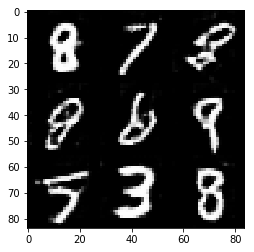

Step3510 Epoch 2/2... Discriminator Loss: 1.2097... Generator Loss: 1.9789
Step3520 Epoch 2/2... Discriminator Loss: 0.7547... Generator Loss: 1.2137
Step3530 Epoch 2/2... Discriminator Loss: 0.9136... Generator Loss: 1.3308
Step3540 Epoch 2/2... Discriminator Loss: 1.0585... Generator Loss: 0.8088
Step3550 Epoch 2/2... Discriminator Loss: 0.8433... Generator Loss: 1.1164
Step3560 Epoch 2/2... Discriminator Loss: 0.8999... Generator Loss: 1.0466
Step3570 Epoch 2/2... Discriminator Loss: 0.8499... Generator Loss: 1.6205
Step3580 Epoch 2/2... Discriminator Loss: 0.9169... Generator Loss: 1.4965
Step3590 Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 0.9271
Step3600 Epoch 2/2... Discriminator Loss: 1.2058... Generator Loss: 0.6735


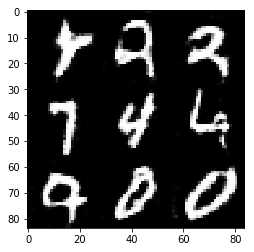

Step3610 Epoch 2/2... Discriminator Loss: 1.0819... Generator Loss: 0.7865
Step3620 Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 0.5293
Step3630 Epoch 2/2... Discriminator Loss: 1.2237... Generator Loss: 2.1308
Step3640 Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 1.5416
Step3650 Epoch 2/2... Discriminator Loss: 0.8258... Generator Loss: 1.1795
Step3660 Epoch 2/2... Discriminator Loss: 1.1823... Generator Loss: 0.6631
Step3670 Epoch 2/2... Discriminator Loss: 0.9575... Generator Loss: 0.9135
Step3680 Epoch 2/2... Discriminator Loss: 1.1542... Generator Loss: 0.6482
Step3690 Epoch 2/2... Discriminator Loss: 0.7835... Generator Loss: 1.3504
Step3700 Epoch 2/2... Discriminator Loss: 1.3366... Generator Loss: 0.5709


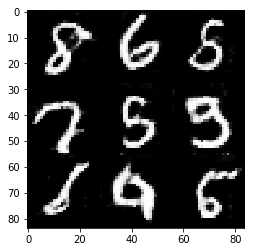

Step3710 Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 0.9334
Step3720 Epoch 2/2... Discriminator Loss: 0.6864... Generator Loss: 1.6358
Step3730 Epoch 2/2... Discriminator Loss: 1.4461... Generator Loss: 0.5293
Step3740 Epoch 2/2... Discriminator Loss: 1.0281... Generator Loss: 1.3242
Step3750 Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 0.7575


In [26]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step10 Epoch 1/1... Discriminator Loss: 3.5403... Generator Loss: 0.0636
Step20 Epoch 1/1... Discriminator Loss: 0.6149... Generator Loss: 3.9081
Step30 Epoch 1/1... Discriminator Loss: 0.6174... Generator Loss: 2.1523
Step40 Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 1.3862
Step50 Epoch 1/1... Discriminator Loss: 2.2957... Generator Loss: 0.2446
Step60 Epoch 1/1... Discriminator Loss: 2.1368... Generator Loss: 0.3919
Step70 Epoch 1/1... Discriminator Loss: 1.6873... Generator Loss: 0.4952
Step80 Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 1.3904
Step90 Epoch 1/1... Discriminator Loss: 1.6314... Generator Loss: 0.5131
Step100 Epoch 1/1... Discriminator Loss: 2.0172... Generator Loss: 0.3303


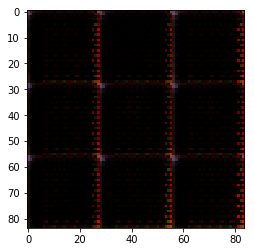

Step110 Epoch 1/1... Discriminator Loss: 2.1526... Generator Loss: 0.3146
Step120 Epoch 1/1... Discriminator Loss: 1.8041... Generator Loss: 0.3825
Step130 Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 2.3545
Step140 Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.9320
Step150 Epoch 1/1... Discriminator Loss: 1.6897... Generator Loss: 0.4521
Step160 Epoch 1/1... Discriminator Loss: 1.7987... Generator Loss: 0.5219
Step170 Epoch 1/1... Discriminator Loss: 2.4249... Generator Loss: 0.2229
Step180 Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.8659
Step190 Epoch 1/1... Discriminator Loss: 1.8223... Generator Loss: 0.4685
Step200 Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.9608


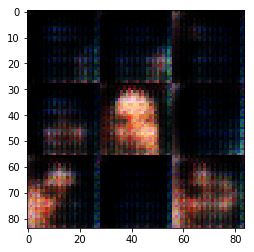

Step210 Epoch 1/1... Discriminator Loss: 1.6365... Generator Loss: 0.5068
Step220 Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.7342
Step230 Epoch 1/1... Discriminator Loss: 1.8295... Generator Loss: 0.3398
Step240 Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.7037
Step250 Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 1.1158
Step260 Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.9786
Step270 Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 1.1902
Step280 Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.7041
Step290 Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6334
Step300 Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.6371


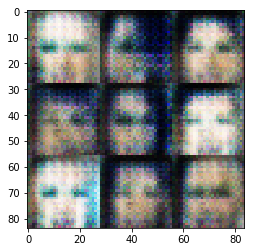

Step310 Epoch 1/1... Discriminator Loss: 2.0213... Generator Loss: 0.2907
Step320 Epoch 1/1... Discriminator Loss: 1.6492... Generator Loss: 0.5271
Step330 Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.6564
Step340 Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7472
Step350 Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.9676
Step360 Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 1.3076
Step370 Epoch 1/1... Discriminator Loss: 1.8121... Generator Loss: 0.4219
Step380 Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.6811
Step390 Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.7204
Step400 Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.7202


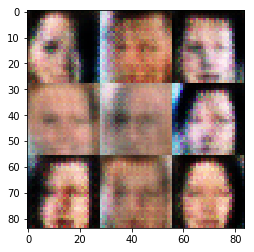

Step410 Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6752
Step420 Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.5638
Step430 Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 1.2219
Step440 Epoch 1/1... Discriminator Loss: 1.6379... Generator Loss: 0.4483
Step450 Epoch 1/1... Discriminator Loss: 1.6033... Generator Loss: 0.6285
Step460 Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.8318
Step470 Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 0.9441
Step480 Epoch 1/1... Discriminator Loss: 1.6979... Generator Loss: 0.4041
Step490 Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.8585
Step500 Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.9425


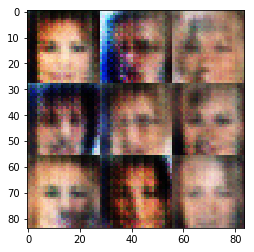

Step510 Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.6043
Step520 Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.5629
Step530 Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.7260
Step540 Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 1.0373
Step550 Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7487
Step560 Epoch 1/1... Discriminator Loss: 1.6104... Generator Loss: 0.4462
Step570 Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.5908
Step580 Epoch 1/1... Discriminator Loss: 1.7151... Generator Loss: 0.4576
Step590 Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.6759
Step600 Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.9999


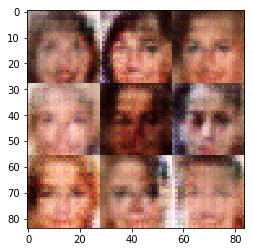

Step610 Epoch 1/1... Discriminator Loss: 1.7890... Generator Loss: 0.3837
Step620 Epoch 1/1... Discriminator Loss: 1.6118... Generator Loss: 0.6474
Step630 Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 0.5159
Step640 Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.8848
Step650 Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 1.0510
Step660 Epoch 1/1... Discriminator Loss: 1.6404... Generator Loss: 0.4735
Step670 Epoch 1/1... Discriminator Loss: 1.7148... Generator Loss: 0.4871
Step680 Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7331
Step690 Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.8428
Step700 Epoch 1/1... Discriminator Loss: 1.9199... Generator Loss: 0.4364


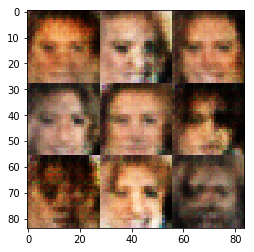

Step710 Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.6662
Step720 Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.5534
Step730 Epoch 1/1... Discriminator Loss: 1.7963... Generator Loss: 0.5107
Step740 Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.9021
Step750 Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.9384
Step760 Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.6108
Step770 Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6713
Step780 Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7469
Step790 Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.7020
Step800 Epoch 1/1... Discriminator Loss: 1.7623... Generator Loss: 0.5151


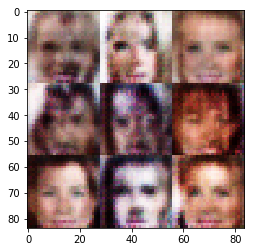

Step810 Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.6729
Step820 Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.7277
Step830 Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.5894
Step840 Epoch 1/1... Discriminator Loss: 1.5816... Generator Loss: 0.6791
Step850 Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7043
Step860 Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7192
Step870 Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7778
Step880 Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.6593
Step890 Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.6487
Step900 Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.8524


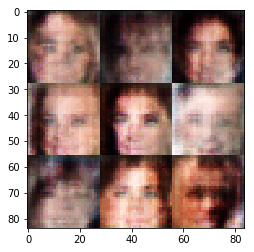

Step910 Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6536
Step920 Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.6313
Step930 Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.9993
Step940 Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.6771
Step950 Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.6418
Step960 Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.7641
Step970 Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.6413
Step980 Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.7385
Step990 Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.8070
Step1000 Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7026


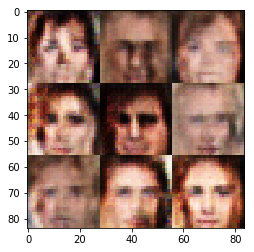

Step1010 Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7910
Step1020 Epoch 1/1... Discriminator Loss: 1.6035... Generator Loss: 0.7056
Step1030 Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 1.0614
Step1040 Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.8396
Step1050 Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.9021
Step1060 Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.8089
Step1070 Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.9284
Step1080 Epoch 1/1... Discriminator Loss: 1.5590... Generator Loss: 0.6213
Step1090 Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 0.5833
Step1100 Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7562


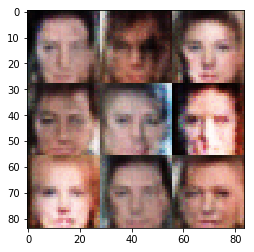

Step1110 Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.6933
Step1120 Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7087
Step1130 Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.8302
Step1140 Epoch 1/1... Discriminator Loss: 1.6502... Generator Loss: 0.5701
Step1150 Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.7604
Step1160 Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.6266
Step1170 Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.7912
Step1180 Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7433
Step1190 Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6414
Step1200 Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.8601


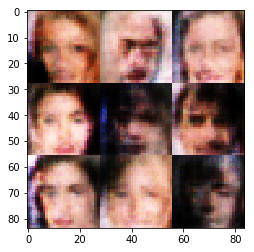

Step1210 Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.8854
Step1220 Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7741
Step1230 Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7233
Step1240 Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.8123
Step1250 Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.6516
Step1260 Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.8020
Step1270 Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.7194
Step1280 Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.6892
Step1290 Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.7670
Step1300 Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.6381


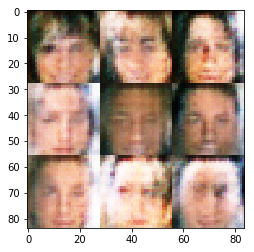

Step1310 Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7443
Step1320 Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7663
Step1330 Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.8774
Step1340 Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.8540
Step1350 Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7546
Step1360 Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.7035
Step1370 Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.7149
Step1380 Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.5808
Step1390 Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.7097
Step1400 Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.0920


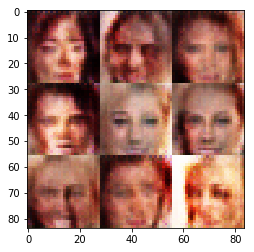

Step1410 Epoch 1/1... Discriminator Loss: 1.6364... Generator Loss: 0.5225
Step1420 Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6423
Step1430 Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.7371
Step1440 Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.8580
Step1450 Epoch 1/1... Discriminator Loss: 1.5494... Generator Loss: 0.5819
Step1460 Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.7821
Step1470 Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.9017
Step1480 Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.5741
Step1490 Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.6752
Step1500 Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.6776


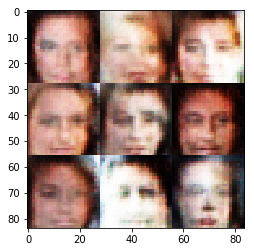

Step1510 Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7106
Step1520 Epoch 1/1... Discriminator Loss: 1.5709... Generator Loss: 0.6038
Step1530 Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.8426
Step1540 Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7220
Step1550 Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.8452
Step1560 Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7369
Step1570 Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.6519
Step1580 Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7240
Step1590 Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.6609
Step1600 Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.6921


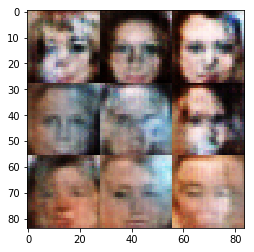

Step1610 Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7071
Step1620 Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.6485
Step1630 Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.8424
Step1640 Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.8412
Step1650 Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7510
Step1660 Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.5624
Step1670 Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.9893
Step1680 Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.7805
Step1690 Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7362
Step1700 Epoch 1/1... Discriminator Loss: 1.5955... Generator Loss: 0.4614


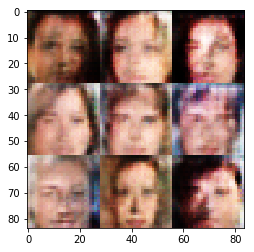

Step1710 Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 1.0334
Step1720 Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 0.9404
Step1730 Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 1.0290
Step1740 Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6136
Step1750 Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.9513
Step1760 Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.5862
Step1770 Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.8994
Step1780 Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.6978
Step1790 Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.7184
Step1800 Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.8300


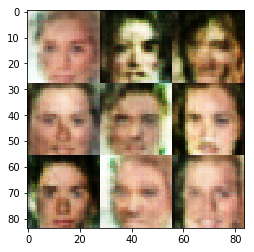

Step1810 Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.8718
Step1820 Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.9202
Step1830 Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6721
Step1840 Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.6131
Step1850 Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6606
Step1860 Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.7823
Step1870 Epoch 1/1... Discriminator Loss: 1.5708... Generator Loss: 0.5753
Step1880 Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.7127
Step1890 Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.8221
Step1900 Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.6846


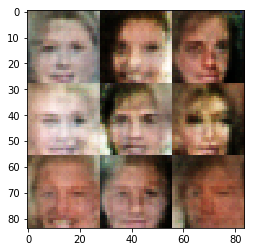

Step1910 Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.7567
Step1920 Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 1.0643
Step1930 Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.6882
Step1940 Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.9327
Step1950 Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.6941
Step1960 Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.7439
Step1970 Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.4718
Step1980 Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.7014
Step1990 Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.6027
Step2000 Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.9824


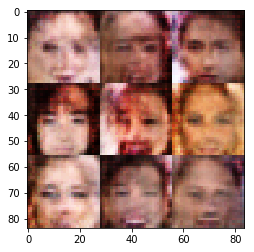

Step2010 Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6140
Step2020 Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.8029
Step2030 Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.8954
Step2040 Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.6479
Step2050 Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.7328
Step2060 Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.9429
Step2070 Epoch 1/1... Discriminator Loss: 1.6056... Generator Loss: 0.6193
Step2080 Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.9341
Step2090 Epoch 1/1... Discriminator Loss: 1.5757... Generator Loss: 0.5258
Step2100 Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.5821


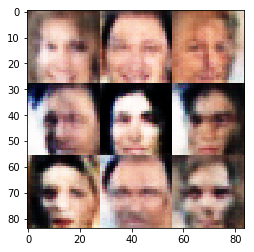

Step2110 Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.5898
Step2120 Epoch 1/1... Discriminator Loss: 1.6964... Generator Loss: 0.7180
Step2130 Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.6807
Step2140 Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.7755
Step2150 Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.8550
Step2160 Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.9533
Step2170 Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.8063
Step2180 Epoch 1/1... Discriminator Loss: 1.6010... Generator Loss: 0.4838
Step2190 Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.6975
Step2200 Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 1.0740


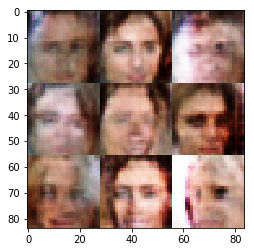

Step2210 Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 1.1138
Step2220 Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.6898
Step2230 Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.7241
Step2240 Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.9460
Step2250 Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.6804
Step2260 Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.8826
Step2270 Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7336
Step2280 Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 0.4915
Step2290 Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.8464
Step2300 Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.6356


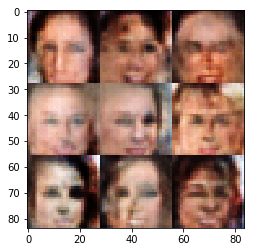

Step2310 Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.8114
Step2320 Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.5776
Step2330 Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7332
Step2340 Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.7687
Step2350 Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.6201
Step2360 Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 1.0029
Step2370 Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7331
Step2380 Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.9485
Step2390 Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.7900
Step2400 Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.8495


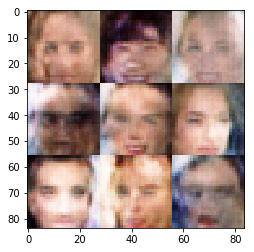

Step2410 Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.7323
Step2420 Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.6581
Step2430 Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7071
Step2440 Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.5919
Step2450 Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.7429
Step2460 Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.9002
Step2470 Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6457
Step2480 Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7281
Step2490 Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.7687
Step2500 Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.8908


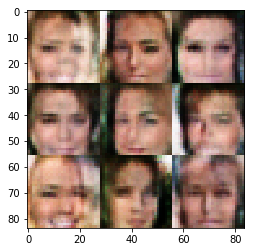

Step2510 Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.5962
Step2520 Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.9281
Step2530 Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.9413
Step2540 Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.7244
Step2550 Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.7877
Step2560 Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.8289
Step2570 Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.6757
Step2580 Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.8974
Step2590 Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.6958
Step2600 Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.6415


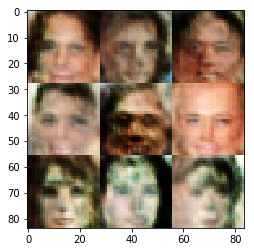

Step2610 Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.8477
Step2620 Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7220
Step2630 Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.6709
Step2640 Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7371
Step2650 Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.9077
Step2660 Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7439
Step2670 Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.6502
Step2680 Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 0.4566
Step2690 Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.9032
Step2700 Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.8935


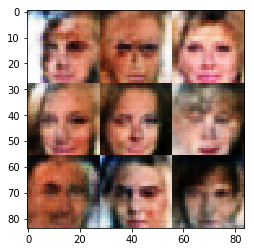

Step2710 Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7435
Step2720 Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.8181
Step2730 Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.6922
Step2740 Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.8335
Step2750 Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7885
Step2760 Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.9106
Step2770 Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.9380
Step2780 Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.7091
Step2790 Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.7727
Step2800 Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.6958


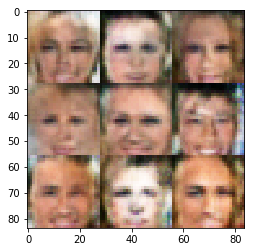

Step2810 Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.8879
Step2820 Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.6828
Step2830 Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.7169
Step2840 Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.6346
Step2850 Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.9445
Step2860 Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.6197
Step2870 Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.9266
Step2880 Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.6314
Step2890 Epoch 1/1... Discriminator Loss: 1.6262... Generator Loss: 0.6062
Step2900 Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.6719


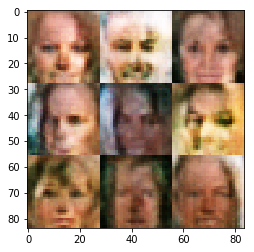

Step2910 Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7890
Step2920 Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.6467
Step2930 Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.5968
Step2940 Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6835
Step2950 Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.5689
Step2960 Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.7106
Step2970 Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.8494
Step2980 Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.8305
Step2990 Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.7501
Step3000 Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.5680


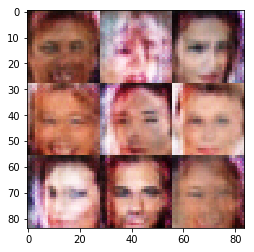

Step3010 Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.6927
Step3020 Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.8780
Step3030 Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6447
Step3040 Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.7752
Step3050 Epoch 1/1... Discriminator Loss: 1.5775... Generator Loss: 0.6305
Step3060 Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.8212
Step3070 Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.7580
Step3080 Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.7181
Step3090 Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.9415
Step3100 Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.7531


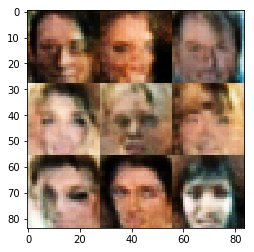

Step3110 Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.7508
Step3120 Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.6984
Step3130 Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 1.0156
Step3140 Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.6609
Step3150 Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7191
Step3160 Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.8681
Step3170 Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.9428
Step3180 Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.9026
Step3190 Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.7440
Step3200 Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7525


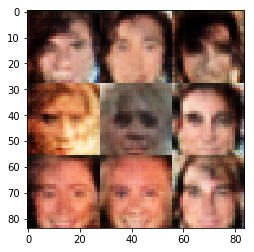

Step3210 Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.5507
Step3220 Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.5717
Step3230 Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.7002
Step3240 Epoch 1/1... Discriminator Loss: 1.6983... Generator Loss: 0.6090
Step3250 Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8726
Step3260 Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.6503
Step3270 Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.8551
Step3280 Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.6858
Step3290 Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.7807
Step3300 Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7085


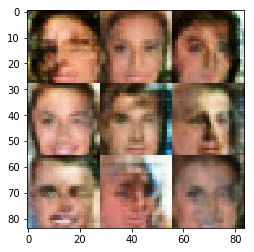

Step3310 Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.7157
Step3320 Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.8289
Step3330 Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 0.9277
Step3340 Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.6315
Step3350 Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.6946
Step3360 Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.8716
Step3370 Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6279
Step3380 Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7410
Step3390 Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.7347
Step3400 Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.8627


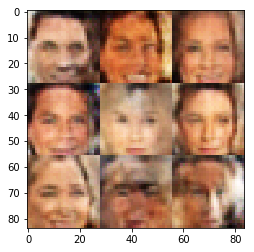

Step3410 Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.8649
Step3420 Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7448
Step3430 Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.6160
Step3440 Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.8296
Step3450 Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.6870
Step3460 Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.6483
Step3470 Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.8783
Step3480 Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.8185
Step3490 Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.8062
Step3500 Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.6350


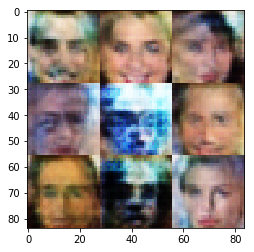

Step3510 Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7548
Step3520 Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.5554
Step3530 Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.9556
Step3540 Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.7133
Step3550 Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.7619
Step3560 Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.7269
Step3570 Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7334
Step3580 Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 1.0382
Step3590 Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.8158
Step3600 Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.7379


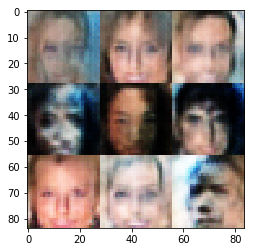

Step3610 Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.9374
Step3620 Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.8436
Step3630 Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.7291
Step3640 Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.7460
Step3650 Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7302
Step3660 Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.8190
Step3670 Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.7661
Step3680 Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.7611
Step3690 Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.6573
Step3700 Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.8022


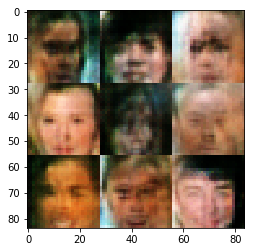

Step3710 Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7455
Step3720 Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7007
Step3730 Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 1.1270
Step3740 Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.8276
Step3750 Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.7222
Step3760 Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.6102
Step3770 Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.6321
Step3780 Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6811
Step3790 Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.6792
Step3800 Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.8181


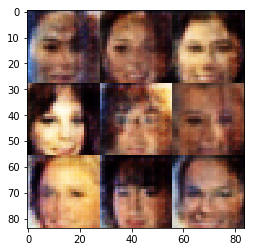

Step3810 Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.7671
Step3820 Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.7546
Step3830 Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.8023
Step3840 Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.8280
Step3850 Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6435
Step3860 Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7281
Step3870 Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.8399
Step3880 Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.6559
Step3890 Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7382
Step3900 Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.9184


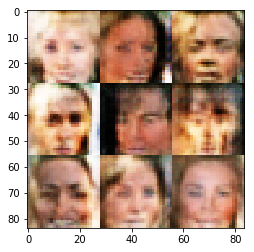

Step3910 Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.7703
Step3920 Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.7831
Step3930 Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.6394
Step3940 Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.9077
Step3950 Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.9868
Step3960 Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.7460
Step3970 Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.6743
Step3980 Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.8095
Step3990 Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.8601
Step4000 Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.8800


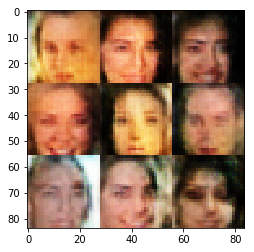

Step4010 Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.7687
Step4020 Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6707
Step4030 Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7576
Step4040 Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.9316
Step4050 Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.5734
Step4060 Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.5481
Step4070 Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6038
Step4080 Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6971
Step4090 Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.7938
Step4100 Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7883


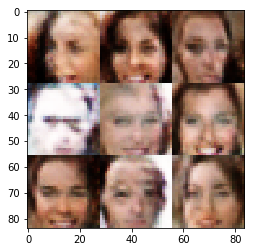

Step4110 Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.7910
Step4120 Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8172
Step4130 Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7695
Step4140 Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.6042
Step4150 Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7008
Step4160 Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.5895
Step4170 Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.5450
Step4180 Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.7440
Step4190 Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.6936
Step4200 Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.7325


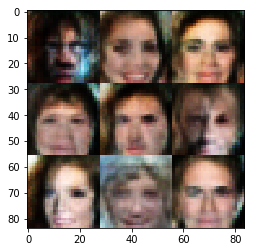

Step4210 Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.8124
Step4220 Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.6853
Step4230 Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.6536
Step4240 Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.8416
Step4250 Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.7424
Step4260 Epoch 1/1... Discriminator Loss: 1.6667... Generator Loss: 0.4428
Step4270 Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.7438
Step4280 Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7309
Step4290 Epoch 1/1... Discriminator Loss: 1.5664... Generator Loss: 0.5713
Step4300 Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7902


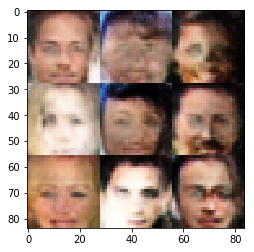

Step4310 Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7481
Step4320 Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.6039
Step4330 Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6529
Step4340 Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7981
Step4350 Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.7184
Step4360 Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.8013
Step4370 Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.6088
Step4380 Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.9049
Step4390 Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.6169
Step4400 Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.6434


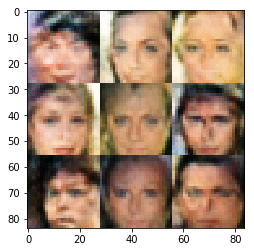

Step4410 Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.6142
Step4420 Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.7507
Step4430 Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.6644
Step4440 Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.7761
Step4450 Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.7017
Step4460 Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.7785
Step4470 Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.8810
Step4480 Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.8635
Step4490 Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7905
Step4500 Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.6555


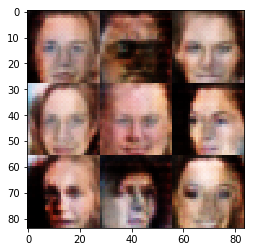

Step4510 Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.8746
Step4520 Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7199
Step4530 Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.8494
Step4540 Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7944
Step4550 Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.6622
Step4560 Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.8689
Step4570 Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.9263
Step4580 Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.7288
Step4590 Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6965
Step4600 Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.8610


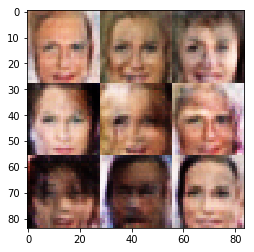

Step4610 Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6317
Step4620 Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.5608
Step4630 Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.7064
Step4640 Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.6565
Step4650 Epoch 1/1... Discriminator Loss: 1.5706... Generator Loss: 0.6541
Step4660 Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.8227
Step4670 Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6400
Step4680 Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.8515
Step4690 Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.7577
Step4700 Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.7585


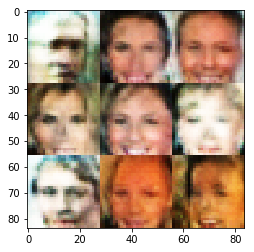

Step4710 Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6642
Step4720 Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7525
Step4730 Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.7669
Step4740 Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.7944
Step4750 Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7327
Step4760 Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.9472
Step4770 Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6780
Step4780 Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7832
Step4790 Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.8282
Step4800 Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.6158


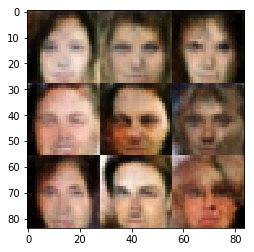

Step4810 Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.8603
Step4820 Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.7760
Step4830 Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.8879
Step4840 Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6870
Step4850 Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6277
Step4860 Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.8116
Step4870 Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.8514
Step4880 Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.6175
Step4890 Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7830
Step4900 Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.7129


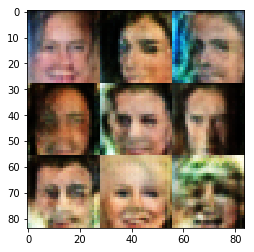

Step4910 Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.7806
Step4920 Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.8291
Step4930 Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.7138
Step4940 Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.8118
Step4950 Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.6640
Step4960 Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.6926
Step4970 Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.6941
Step4980 Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.6827
Step4990 Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.9432
Step5000 Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.7795


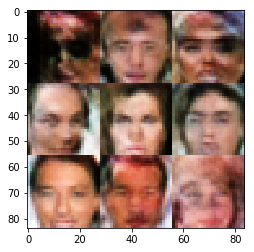

Step5010 Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.6354
Step5020 Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.8178
Step5030 Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.7159
Step5040 Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6677
Step5050 Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.6881
Step5060 Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.8466
Step5070 Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.7485
Step5080 Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.6809
Step5090 Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7524
Step5100 Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.7353


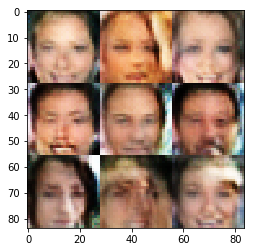

Step5110 Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7930
Step5120 Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.7359
Step5130 Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.6590
Step5140 Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.8768
Step5150 Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.6300
Step5160 Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.8242
Step5170 Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.7891
Step5180 Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7763
Step5190 Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.9123
Step5200 Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.8557


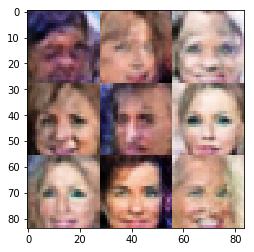

Step5210 Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.6872
Step5220 Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.6419
Step5230 Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.6770
Step5240 Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.7720
Step5250 Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.8111
Step5260 Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.7191
Step5270 Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7358
Step5280 Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.5983
Step5290 Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.8367
Step5300 Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.8028


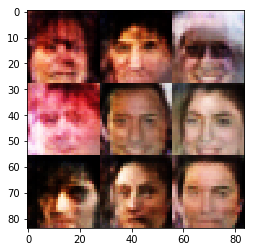

Step5310 Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.7572
Step5320 Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.8276
Step5330 Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6519
Step5340 Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7216
Step5350 Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6568
Step5360 Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.7364
Step5370 Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6627
Step5380 Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7964
Step5390 Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.7212
Step5400 Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7684


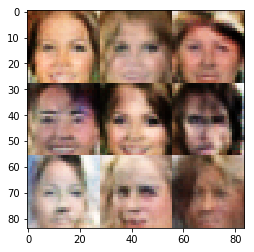

Step5410 Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.8249
Step5420 Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.7432
Step5430 Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.7637
Step5440 Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8432
Step5450 Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.6869
Step5460 Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.7424
Step5470 Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.8929
Step5480 Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.7935
Step5490 Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7520
Step5500 Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7765


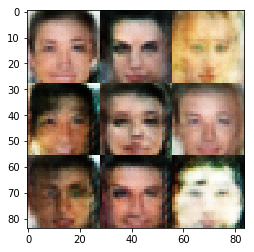

Step5510 Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.5981
Step5520 Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.7578
Step5530 Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.7516
Step5540 Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6072
Step5550 Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.5991
Step5560 Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.6752
Step5570 Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.6615
Step5580 Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.6825
Step5590 Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7139
Step5600 Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6879


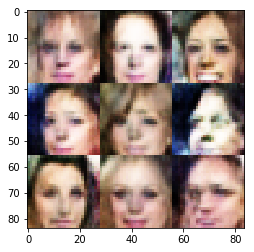

Step5610 Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.8020
Step5620 Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.7972
Step5630 Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7656
Step5640 Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6204
Step5650 Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6618
Step5660 Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.8459
Step5670 Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.8399
Step5680 Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7024
Step5690 Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.8087
Step5700 Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7390


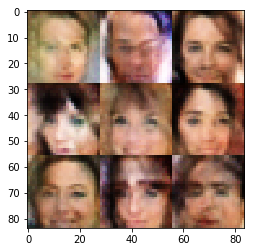

Step5710 Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.9582
Step5720 Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.8093
Step5730 Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8573
Step5740 Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.8034
Step5750 Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.7229
Step5760 Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.7181
Step5770 Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7760
Step5780 Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.7859
Step5790 Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7755
Step5800 Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.7850


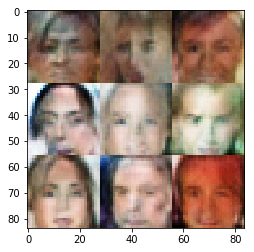

Step5810 Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.7494
Step5820 Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.6132
Step5830 Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6979
Step5840 Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.6396
Step5850 Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.5882
Step5860 Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.8788
Step5870 Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.7809
Step5880 Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.6684
Step5890 Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.6772
Step5900 Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6273


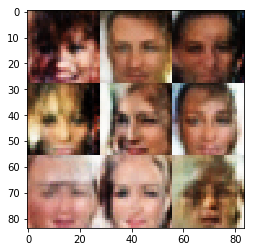

Step5910 Epoch 1/1... Discriminator Loss: 1.5872... Generator Loss: 0.5865
Step5920 Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.7141
Step5930 Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.7064
Step5940 Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7381
Step5950 Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.7399
Step5960 Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7578
Step5970 Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.7868
Step5980 Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7236
Step5990 Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.8521
Step6000 Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6684


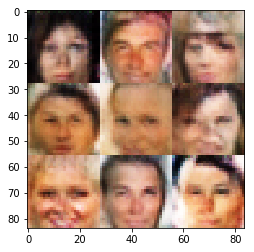

Step6010 Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7961
Step6020 Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.5995
Step6030 Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.6605
Step6040 Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7684
Step6050 Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.7046
Step6060 Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.6453
Step6070 Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.7831
Step6080 Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.9772
Step6090 Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.7537
Step6100 Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6538


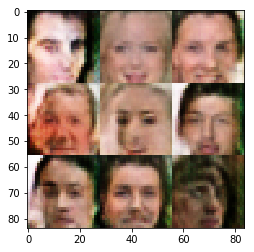

Step6110 Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.7532
Step6120 Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.6574
Step6130 Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.8226
Step6140 Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.6983
Step6150 Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7663
Step6160 Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6885
Step6170 Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.6630
Step6180 Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.6921
Step6190 Epoch 1/1... Discriminator Loss: 1.5878... Generator Loss: 0.5556
Step6200 Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.8263


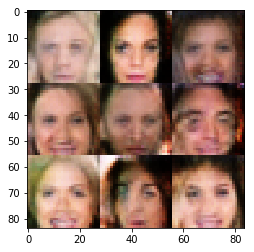

Step6210 Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7390
Step6220 Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.6410
Step6230 Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.8533
Step6240 Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6966
Step6250 Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.8222
Step6260 Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7538
Step6270 Epoch 1/1... Discriminator Loss: 1.5290... Generator Loss: 0.6371
Step6280 Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6500
Step6290 Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.7550
Step6300 Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7180


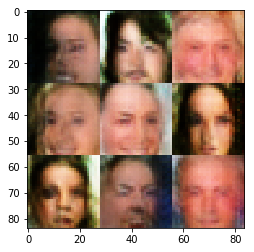

Step6310 Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.6434
Step6320 Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7540
Step6330 Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.7402
Step6340 Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.8206
Step6350 Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.6042
Step6360 Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6838
Step6370 Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.7227
Step6380 Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7519
Step6390 Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.8270
Step6400 Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6923


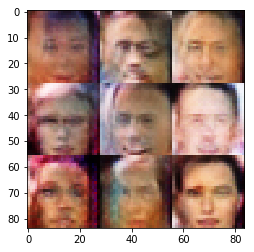

Step6410 Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.7923
Step6420 Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7429
Step6430 Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.6834
Step6440 Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.7480
Step6450 Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.9261
Step6460 Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7724
Step6470 Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6387
Step6480 Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8240
Step6490 Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.7210
Step6500 Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.6296


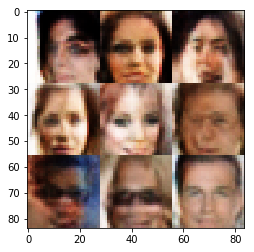

Step6510 Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7272
Step6520 Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6788
Step6530 Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.8411
Step6540 Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.7805
Step6550 Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.6160
Step6560 Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7720
Step6570 Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7189
Step6580 Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.7919
Step6590 Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.8839
Step6600 Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.8609


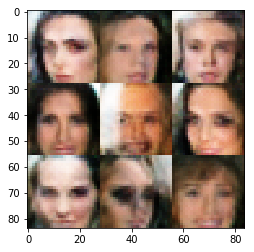

Step6610 Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.7163
Step6620 Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7256
Step6630 Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6930
Step6640 Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.6133
Step6650 Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7748
Step6660 Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.7977
Step6670 Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.7606
Step6680 Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.7661
Step6690 Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.8211
Step6700 Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.5878


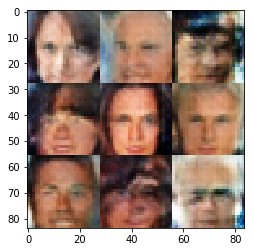

Step6710 Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.7811
Step6720 Epoch 1/1... Discriminator Loss: 1.6252... Generator Loss: 0.5738
Step6730 Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.7514
Step6740 Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.7610
Step6750 Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.7451
Step6760 Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7425
Step6770 Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.7539
Step6780 Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.8125
Step6790 Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.7613
Step6800 Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7612


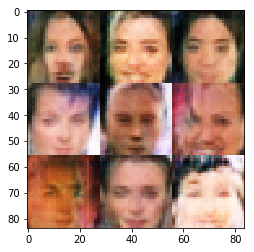

Step6810 Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7256
Step6820 Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7742
Step6830 Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.8108
Step6840 Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.7757
Step6850 Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.8215
Step6860 Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7083
Step6870 Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7338
Step6880 Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7364
Step6890 Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.6909
Step6900 Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7405


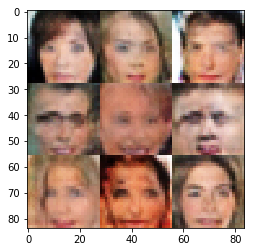

Step6910 Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.7628
Step6920 Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7316
Step6930 Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7280
Step6940 Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.7597
Step6950 Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.7986
Step6960 Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.5812
Step6970 Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7223
Step6980 Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.6781
Step6990 Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.7952
Step7000 Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7056


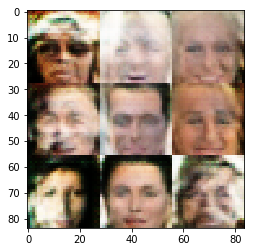

Step7010 Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.7785
Step7020 Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.7092
Step7030 Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7038
Step7040 Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7995
Step7050 Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6279
Step7060 Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.7705
Step7070 Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7743
Step7080 Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7004
Step7090 Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.6694
Step7100 Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.7401


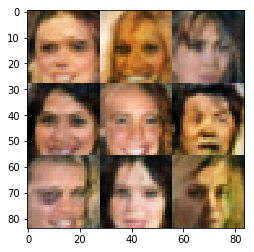

Step7110 Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.7629
Step7120 Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.7615
Step7130 Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.7841
Step7140 Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7301
Step7150 Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.8309
Step7160 Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6471
Step7170 Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7255
Step7180 Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.8667
Step7190 Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.8368
Step7200 Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7556


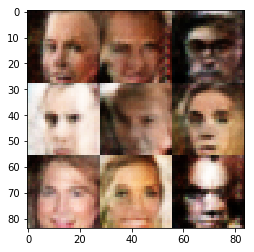

Step7210 Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.8350
Step7220 Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.6806
Step7230 Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7045
Step7240 Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7612
Step7250 Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7703
Step7260 Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7898
Step7270 Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.6466
Step7280 Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7667
Step7290 Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7842
Step7300 Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7287


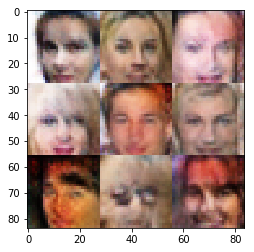

Step7310 Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.7251
Step7320 Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6821
Step7330 Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.6290
Step7340 Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6898
Step7350 Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.7598
Step7360 Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.8664
Step7370 Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.6727
Step7380 Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.9328
Step7390 Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.9472
Step7400 Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.7643


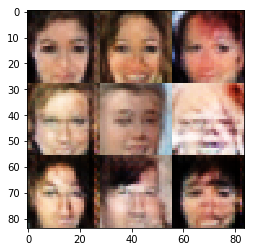

Step7410 Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.6317
Step7420 Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7092
Step7430 Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7536
Step7440 Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.7595
Step7450 Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.7278
Step7460 Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6771
Step7470 Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7280
Step7480 Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.8009
Step7490 Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.9243
Step7500 Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.7073


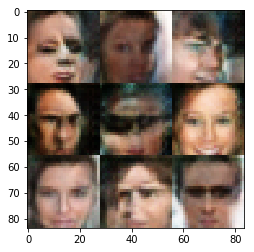

Step7510 Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.7345
Step7520 Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.8164
Step7530 Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.7373
Step7540 Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.7562
Step7550 Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.7265
Step7560 Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.8118
Step7570 Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7717
Step7580 Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.7696
Step7590 Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.8141
Step7600 Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6986


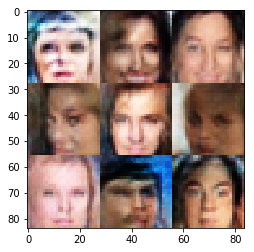

Step7610 Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.7524
Step7620 Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.7929
Step7630 Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.8105
Step7640 Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7528
Step7650 Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6314
Step7660 Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.8075
Step7670 Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.8504
Step7680 Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.8990
Step7690 Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7528
Step7700 Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7164


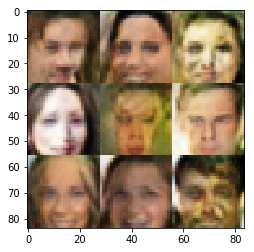

Step7710 Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7251
Step7720 Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7373
Step7730 Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.8737
Step7740 Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.8903
Step7750 Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7433
Step7760 Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.8301
Step7770 Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7265
Step7780 Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.8211
Step7790 Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7130
Step7800 Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7881


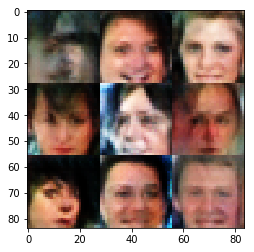

Step7810 Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.6752
Step7820 Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.8206
Step7830 Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.6670
Step7840 Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7029
Step7850 Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7069
Step7860 Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.5949
Step7870 Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6989
Step7880 Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.7852
Step7890 Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6834
Step7900 Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.7117


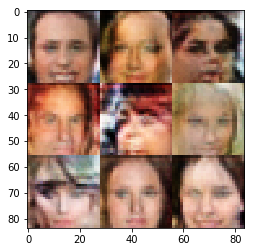

Step7910 Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7712
Step7920 Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.7946
Step7930 Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.8337
Step7940 Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.8108
Step7950 Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6338
Step7960 Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.7586
Step7970 Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.8089
Step7980 Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.7566
Step7990 Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.8159
Step8000 Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.7928


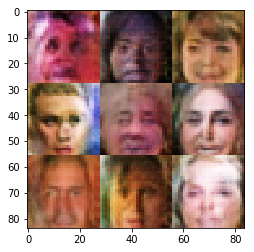

Step8010 Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6607
Step8020 Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.7495
Step8030 Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.8104
Step8040 Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.7832
Step8050 Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.7902
Step8060 Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7535
Step8070 Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7516
Step8080 Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.8095
Step8090 Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.6114
Step8100 Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.8467


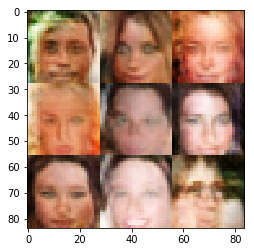

Step8110 Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.7572
Step8120 Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.7403
Step8130 Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7617
Step8140 Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.8588
Step8150 Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.6334
Step8160 Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.8601
Step8170 Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7455
Step8180 Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7240
Step8190 Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.6423
Step8200 Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.8099


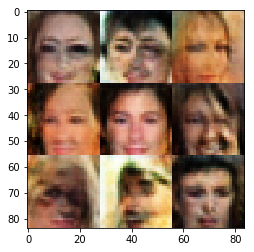

Step8210 Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6798
Step8220 Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.7691
Step8230 Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 0.6031
Step8240 Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.6583
Step8250 Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.8895
Step8260 Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.8560
Step8270 Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7593
Step8280 Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7873
Step8290 Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7028
Step8300 Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7741


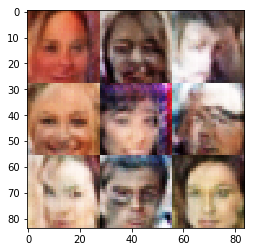

Step8310 Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.7672
Step8320 Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.6069
Step8330 Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7170
Step8340 Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.7778
Step8350 Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.8102
Step8360 Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.6151
Step8370 Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.6380
Step8380 Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.8290
Step8390 Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.8092
Step8400 Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7367


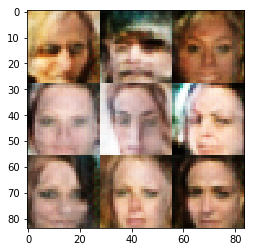

Step8410 Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.7756
Step8420 Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.7495
Step8430 Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.8201
Step8440 Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.7640
Step8450 Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.8406
Step8460 Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.7387
Step8470 Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.7738
Step8480 Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.8395
Step8490 Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.8262
Step8500 Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.7812


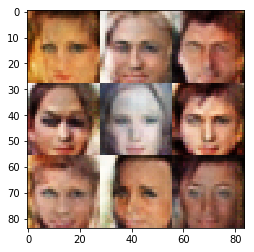

Step8510 Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7694
Step8520 Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6550
Step8530 Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.7226
Step8540 Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.8870
Step8550 Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.6874
Step8560 Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6738
Step8570 Epoch 1/1... Discriminator Loss: 1.5972... Generator Loss: 0.5394
Step8580 Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.7238
Step8590 Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7355
Step8600 Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6720


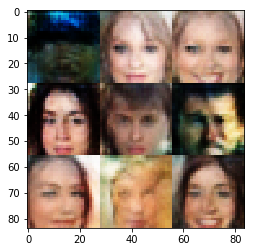

Step8610 Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7012
Step8620 Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7639
Step8630 Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.7502
Step8640 Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7093
Step8650 Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.7442
Step8660 Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.6271
Step8670 Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7157
Step8680 Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6593
Step8690 Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7674
Step8700 Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7826


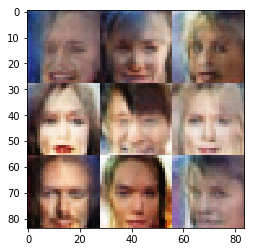

Step8710 Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7263
Step8720 Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.7195
Step8730 Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.6299
Step8740 Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7021
Step8750 Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.7813
Step8760 Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.8159
Step8770 Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.7874
Step8780 Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7523
Step8790 Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.7191
Step8800 Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7889


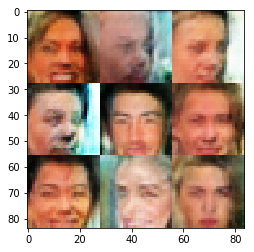

Step8810 Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.6752
Step8820 Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.6620
Step8830 Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.8896
Step8840 Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.7770
Step8850 Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7775
Step8860 Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6953
Step8870 Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.6277
Step8880 Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7236
Step8890 Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7052
Step8900 Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.8274


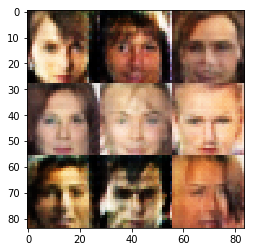

Step8910 Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7018
Step8920 Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7201
Step8930 Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.8311
Step8940 Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6775
Step8950 Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.8738
Step8960 Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6719
Step8970 Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7619
Step8980 Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.7921
Step8990 Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.7484
Step9000 Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.5934


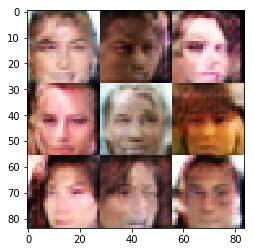

Step9010 Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.5866
Step9020 Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.7564
Step9030 Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.8752
Step9040 Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.5792
Step9050 Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7530
Step9060 Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.8106
Step9070 Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.7430
Step9080 Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.8340
Step9090 Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7681
Step9100 Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7143


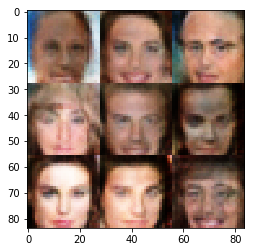

Step9110 Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.7487
Step9120 Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.7602
Step9130 Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.9113
Step9140 Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7446
Step9150 Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.7062
Step9160 Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7952
Step9170 Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.7096
Step9180 Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6693
Step9190 Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.8536
Step9200 Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.8214


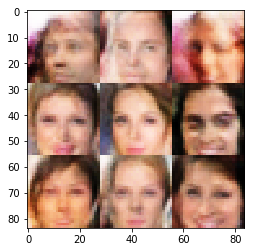

Step9210 Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7220
Step9220 Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.8129
Step9230 Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.8267
Step9240 Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6749
Step9250 Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7270
Step9260 Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.7822
Step9270 Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.7769
Step9280 Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7186
Step9290 Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.8431
Step9300 Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7076


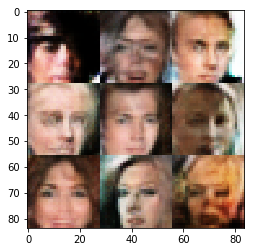

Step9310 Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.5973
Step9320 Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.6820
Step9330 Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.8383
Step9340 Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8152
Step9350 Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7012
Step9360 Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.7112
Step9370 Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7479
Step9380 Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7123
Step9390 Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7362
Step9400 Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.7734


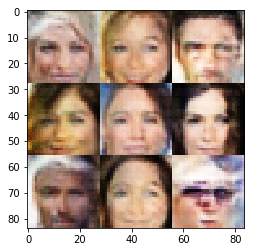

Step9410 Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.8591
Step9420 Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8074
Step9430 Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7532
Step9440 Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.7976
Step9450 Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.7284
Step9460 Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.8180
Step9470 Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.6991
Step9480 Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7425
Step9490 Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.7417
Step9500 Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.8240


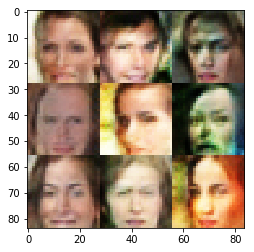

Step9510 Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.6995
Step9520 Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.7324
Step9530 Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.8300
Step9540 Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.8347
Step9550 Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.7266
Step9560 Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6512
Step9570 Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7136
Step9580 Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.8828
Step9590 Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8369
Step9600 Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7862


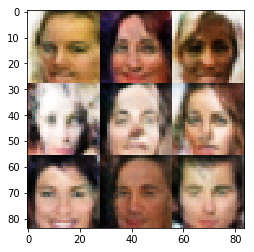

Step9610 Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.7811
Step9620 Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7404
Step9630 Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7843
Step9640 Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.6855
Step9650 Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.8607
Step9660 Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.7254
Step9670 Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7041
Step9680 Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.7497
Step9690 Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.7855
Step9700 Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7061


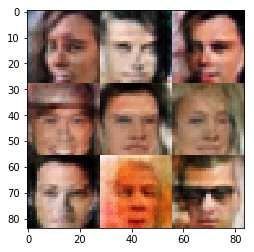

Step9710 Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.7519
Step9720 Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6632
Step9730 Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.7683
Step9740 Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.7925
Step9750 Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.7796
Step9760 Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6961
Step9770 Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.7747
Step9780 Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.7411
Step9790 Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.6537
Step9800 Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.7384


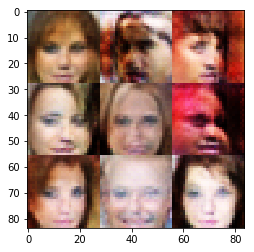

Step9810 Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7950
Step9820 Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7319
Step9830 Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.6555
Step9840 Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6930
Step9850 Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7784
Step9860 Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.8040
Step9870 Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.6789
Step9880 Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7225
Step9890 Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7506
Step9900 Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.8284


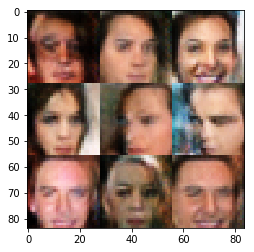

Step9910 Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.8245
Step9920 Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.8017
Step9930 Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.8773
Step9940 Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.6875
Step9950 Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7114
Step9960 Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7035
Step9970 Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7744
Step9980 Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.7979
Step9990 Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.7806
Step10000 Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7656


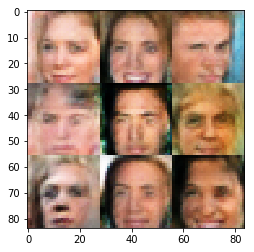

Step10010 Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.9655
Step10020 Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.7685
Step10030 Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.8344
Step10040 Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6613
Step10050 Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.6191
Step10060 Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7397
Step10070 Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.8986
Step10080 Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7221
Step10090 Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7115
Step10100 Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7737


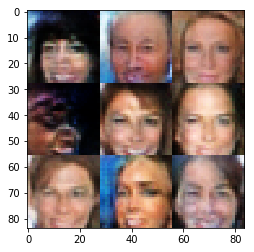

Step10110 Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.7602
Step10120 Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7039
Step10130 Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.8132
Step10140 Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.8086
Step10150 Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.8018
Step10160 Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7571
Step10170 Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6867
Step10180 Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.7265
Step10190 Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.7999
Step10200 Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.8501


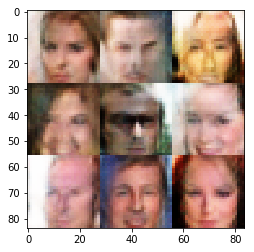

Step10210 Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7862
Step10220 Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.8063
Step10230 Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.6980
Step10240 Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.7796
Step10250 Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.8385
Step10260 Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.6554
Step10270 Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7048
Step10280 Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.8126
Step10290 Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.7678
Step10300 Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6657


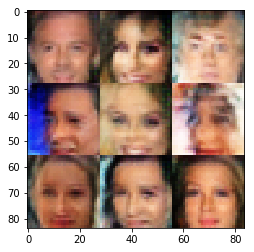

Step10310 Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.8171
Step10320 Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.8029
Step10330 Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6289
Step10340 Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.7328
Step10350 Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7422
Step10360 Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7285
Step10370 Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.6962
Step10380 Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7305
Step10390 Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.8070
Step10400 Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7468


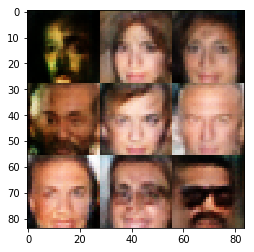

Step10410 Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7191
Step10420 Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.6791
Step10430 Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.7480
Step10440 Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.7877
Step10450 Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6970
Step10460 Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7587
Step10470 Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7582
Step10480 Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7074
Step10490 Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.7093
Step10500 Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7669


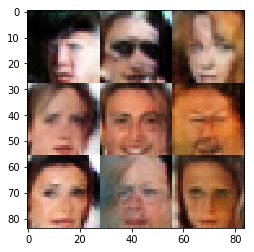

Step10510 Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.7740
Step10520 Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6647
Step10530 Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.6390
Step10540 Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7574
Step10550 Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.8088
Step10560 Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.8254
Step10570 Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.8920
Step10580 Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 0.6609
Step10590 Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.8634
Step10600 Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.9030


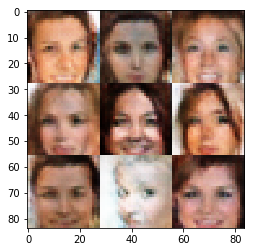

Step10610 Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.6431
Step10620 Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.8526
Step10630 Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.7303
Step10640 Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.7337
Step10650 Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8303
Step10660 Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 0.6514
Step10670 Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.7528
Step10680 Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.8421
Step10690 Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7235
Step10700 Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.6761


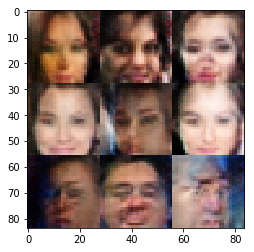

Step10710 Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7692
Step10720 Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7034
Step10730 Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.6221
Step10740 Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.7796
Step10750 Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7687
Step10760 Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7648
Step10770 Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8072
Step10780 Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.7893
Step10790 Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7863
Step10800 Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.9039


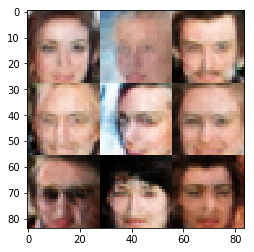

Step10810 Epoch 1/1... Discriminator Loss: 1.5477... Generator Loss: 0.5740
Step10820 Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.7491
Step10830 Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.8014
Step10840 Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.5948
Step10850 Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.7811
Step10860 Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 0.6243
Step10870 Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.6375
Step10880 Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7007
Step10890 Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.7630
Step10900 Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.6731


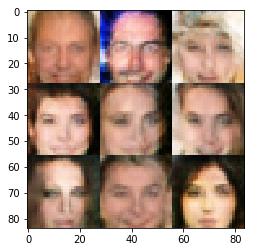

Step10910 Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7949
Step10920 Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.7905
Step10930 Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.7811
Step10940 Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7381
Step10950 Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.8646
Step10960 Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7804
Step10970 Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.7985
Step10980 Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6670
Step10990 Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.8194
Step11000 Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.8195


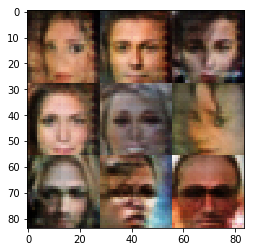

Step11010 Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.6531
Step11020 Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.7880
Step11030 Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.7747
Step11040 Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.8088
Step11050 Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7748
Step11060 Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6857
Step11070 Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.8076
Step11080 Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.7699
Step11090 Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.8313
Step11100 Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.7661


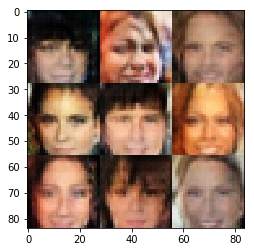

Step11110 Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.7115
Step11120 Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.6894
Step11130 Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.6724
Step11140 Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7795
Step11150 Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.7165
Step11160 Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.7891
Step11170 Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6979
Step11180 Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.8259
Step11190 Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7461
Step11200 Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7052


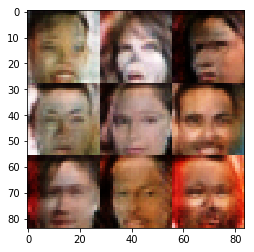

Step11210 Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.6872
Step11220 Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.7962
Step11230 Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.7963
Step11240 Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7526
Step11250 Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6875
Step11260 Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6642
Step11270 Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7279
Step11280 Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8520
Step11290 Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.8551
Step11300 Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7098


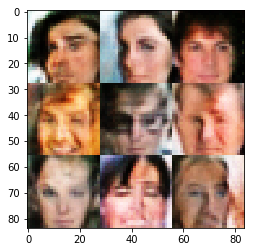

Step11310 Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 0.9114
Step11320 Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.6948
Step11330 Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7584
Step11340 Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.8452
Step11350 Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.6748
Step11360 Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7444
Step11370 Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.8258
Step11380 Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7029
Step11390 Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7277
Step11400 Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6769


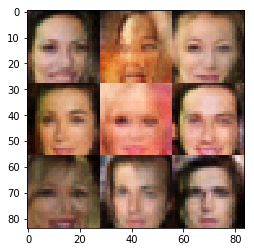

Step11410 Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7807
Step11420 Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.8225
Step11430 Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.6996
Step11440 Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6761
Step11450 Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.7769
Step11460 Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7033
Step11470 Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.8185
Step11480 Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.7876
Step11490 Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7245
Step11500 Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.5870


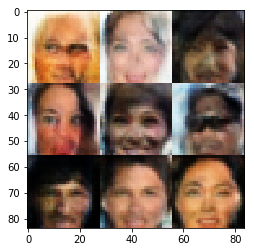

Step11510 Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7022
Step11520 Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6651
Step11530 Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6179
Step11540 Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.8219
Step11550 Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.7597
Step11560 Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.7229
Step11570 Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.7497
Step11580 Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.8178
Step11590 Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7740
Step11600 Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7519


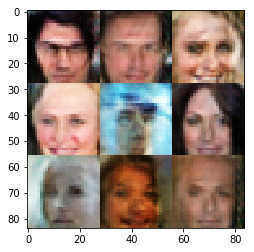

Step11610 Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.7848
Step11620 Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7653
Step11630 Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.7158
Step11640 Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7190
Step11650 Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.7565
Step11660 Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.8380
Step11670 Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6463
Step11680 Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.8115
Step11690 Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7962
Step11700 Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.8169


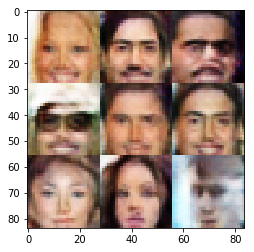

Step11710 Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7647
Step11720 Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.8675
Step11730 Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7033
Step11740 Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.6749
Step11750 Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.8257
Step11760 Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.7952
Step11770 Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.7243
Step11780 Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.7679
Step11790 Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.8124
Step11800 Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7210


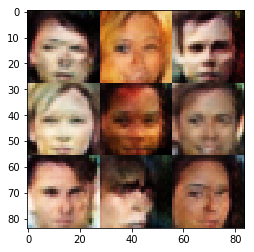

Step11810 Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7166
Step11820 Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.6372
Step11830 Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7555
Step11840 Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.6856
Step11850 Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.7739
Step11860 Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 0.7126
Step11870 Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.8913
Step11880 Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.8241
Step11890 Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.7214
Step11900 Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7246


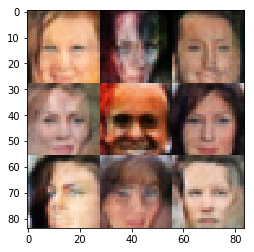

Step11910 Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.7656
Step11920 Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.8432
Step11930 Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.7381
Step11940 Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.8234
Step11950 Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.9379
Step11960 Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.7929
Step11970 Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.7728
Step11980 Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.7324
Step11990 Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.7327
Step12000 Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6648


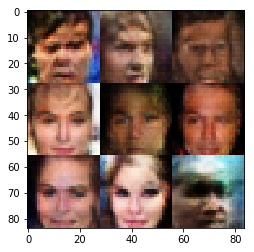

Step12010 Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7908
Step12020 Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7201
Step12030 Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.6817
Step12040 Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.8009
Step12050 Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.8474
Step12060 Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.7071
Step12070 Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.7786
Step12080 Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7611
Step12090 Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.8592
Step12100 Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.8797


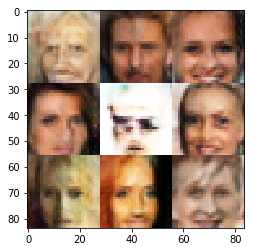

Step12110 Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.7715
Step12120 Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.8468
Step12130 Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.8076
Step12140 Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.8397
Step12150 Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7572
Step12160 Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.8097
Step12170 Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7148
Step12180 Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6891
Step12190 Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.8053
Step12200 Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.6757


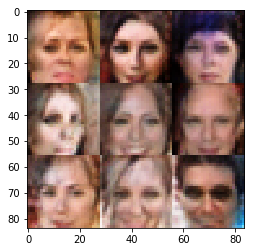

Step12210 Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.6873
Step12220 Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7449
Step12230 Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7513
Step12240 Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7286
Step12250 Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.7080
Step12260 Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.7897
Step12270 Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7227
Step12280 Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.7774
Step12290 Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.6781
Step12300 Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.7516


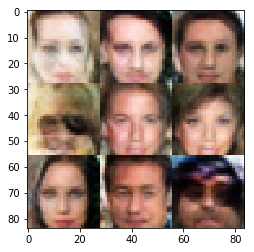

Step12310 Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6598
Step12320 Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.7181
Step12330 Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.7391
Step12340 Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7582
Step12350 Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.6811
Step12360 Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.8378
Step12370 Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.7416
Step12380 Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.7714
Step12390 Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7681
Step12400 Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.7972


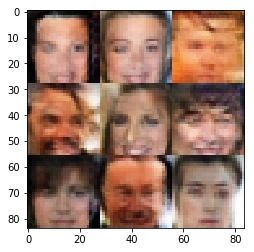

Step12410 Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.6706
Step12420 Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.8241
Step12430 Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7220
Step12440 Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.6745
Step12450 Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7611
Step12460 Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7760
Step12470 Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.7081
Step12480 Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7755
Step12490 Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.7478
Step12500 Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6966


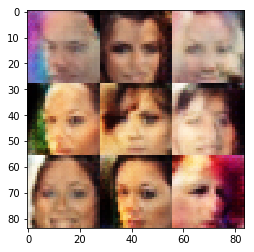

Step12510 Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.8477
Step12520 Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6935
Step12530 Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.6731
Step12540 Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7539
Step12550 Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7263
Step12560 Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6549
Step12570 Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7305
Step12580 Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.7777
Step12590 Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7334
Step12600 Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7890


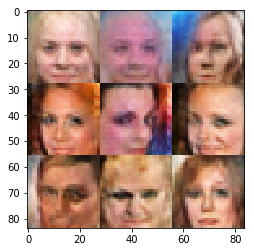

Step12610 Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.8247
Step12620 Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7885
Step12630 Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7418
Step12640 Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7017
Step12650 Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7406
Step12660 Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.6890


In [27]:
batch_size = 16
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.